# Notebook summary of work 

In [1]:
# parent_folder_path = "/Users/haleyoro/Desktop/" # work on library computer
parent_folder_path = "/Users/Haley/Desktop/" # work on local computer

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyabf

Looking at the waveforms (from `Plotting` folder)

Annotations sheet --`App Script`--> unformatted csv files 

unformatted csv files --`process_excel`--> formatted csv files 

## `annotations_loader` : Make `sheets` dict with 38 dataframes of all processed .csvs

Load the cell types data frame to include info when reading .csv sheets

In [3]:
cell_types_df = pd.read_csv(parent_folder_path+"murray-neuroscience-lab/Excel processor/List of cells.csv")
cell_types_df = cell_types_df.dropna(how='all')
cell_types_df = cell_types_df.iloc[:,:4]
cell_types_df.reset_index(drop=True,inplace=True)
sheets_types = cell_types_df["Cell"].unique().tolist()
print("Number of labeled sheets:",len(sheets_types))

Number of labeled sheets: 29


Create a dictionary looping through sheet names to load each sheet annotation as a data frame 
(.csv files were re-formatted using functions in `process_excel`, looping through the downloaded excel sheets from the annotations sheet in google drive. excel sheets were downloaded as .csvs using App Script code)

In [4]:
sheet_names_df = pd.read_csv(parent_folder_path+'murray-neuroscience-lab/Processed CSVs/sheet_names.csv', header=None)
sheet_names = sheet_names_df.iloc[:,0].values
sheets = {}

for sheet in sheet_names:
    file_path = parent_folder_path+"murray-neuroscience-lab/Processed CSVs/"+sheet+".csv"
    df = pd.read_csv(file_path)
    df[["Trace name","Tags","Type"]] = df[["Trace name","Tags","Type"]].astype("string")
    if sheet in sheets_types:
        types = cell_types_df[cell_types_df["Cell"]==sheet]
        if not df.empty:
            df.loc[:,"Cell Type"] = types.iloc[0]["Cell Type"]
            df.loc[:,"Input Resistance"] = types.iloc[0]["Input Resistance"]
            df.loc[:,"Motoneuron"] = types.iloc[0]["Motoneuron"]
            df.loc[:,"Cell"] = types.iloc[0]["Cell"]

    sheets[sheet] = df

# sheets

In [5]:
unlabeled = list(set(sheet_names) - set(sheets_types))
print("Unlabeled annotation sheets:", unlabeled)


Unlabeled annotation sheets: ['2012_12_04_cell2', '2012_06_22_cell3', '2012_04_27_cell1', '2012_10_04_cell1', '2012_06_25_cell3', '2012_12_06_cell5', '2013_03_21_cell2', '2012_12_06_cell2', '2012_12_06_cell6', '2012_12_06_cell3']


Keys are names of sheets

In [6]:
print("Number of sheets:", len(sheets.keys()))
print("Number of labeled sheets:",len(sheets_types))
sheets.keys()

Number of sheets: 39
Number of labeled sheets: 29


dict_keys(['2012_04_25_cell1', '2012_04_25_cell3', '2012_04_27_cell1', '2012_06_22_cell3', '2012_06_25_cell3', '2012_06_29', '2012_08_01_cell1', '2012_08_01_cell3', '2012_08_07', '2012_08_31_cell1', '2012_08_31_cell2', '2012_08_31_cell3', '2012_08_31_cell4', '2012_10_04_cell2', '2012_12_03_cell1', '2012_12_04_cell1', '2012_12_04_cell2', '2012_12_05_cell1', '2012_12_05_cell3', '2012_12_05_cell4', '2012_12_06_cell1', '2012_12_06_cell2', '2012_12_06_cell3', '2012_12_06_cell4', '2012_12_06_cell5', '2012_12_06_cell6', '2013_03_20_cell1', '2013_03_21_cell1', '2013_03_21_cell2', '2013_03_21_cell3', '2013_03_21_cell4', '2013_03_21_cell5', '2013_03_22_cell1', '2013_03_22_cell2', '2013_03_22_cell3', '2013_03_22_cell4', '2013_03_22_cell5', '2013_03_22_cell6', '2012_10_04_cell1'])

Using one sheet name to access the formatted dataframe of the annotations, includes cell type and resistance

In [7]:
sheets['2012_04_25_cell1'].head()

Trace name  ID  On time     Freq               Tags        Type  \
0  2012_04_25_0004   1  1285.99      NaN  bout start; shock  Inhibitory   
1  2012_04_25_0004   2  1305.92  50.1756               <NA>  Inhibitory   
2  2012_04_25_0004   3  1340.95  28.5470               <NA>  Inhibitory   
3  2012_04_25_0004   4  1371.30  32.9489               <NA>  Inhibitory   
4  2012_04_25_0004   5  1405.23  29.4724           bout end  Inhibitory   

   Seconds Cell Type  Input Resistance Motoneuron              Cell  
0  1.28599      vRoP             74.45    primary  2012_04_25_cell1  
1  1.30592      vRoP             74.45    primary  2012_04_25_cell1  
2  1.34095      vRoP             74.45    primary  2012_04_25_cell1  
3  1.37130      vRoP             74.45    primary  2012_04_25_cell1  
4  1.40523      vRoP             74.45    primary  2012_04_25_cell1

Some don't have Cell Type	Input Resistance	Motoneuron columns since it is not in the list of cells spreadsheet

In [8]:
sheets['2013_03_21_cell2'].head()

Trace name   ID   On time     Freq                     Tags  \
0  2013_03_21_0009  1.0   8573.84      NaN  bout start; spontaneous   
1  2013_03_21_0009  2.0   8628.92  18.1554                     <NA>   
2  2013_03_21_0009  3.0   8679.99  19.5810                     <NA>   
3  2013_03_21_0009  4.0   8723.59  22.9358                 bout end   
4  2013_03_21_0009  5.0  11015.75   0.4363  bout start; spontaneous   

            Type   Seconds  
0  Cell-attached   8.57384  
1  Cell-attached   8.62892  
2  Cell-attached   8.67999  
3  Cell-attached   8.72359  
4  Cell-attached  11.01575

## `binwaves_` : make abfs dict to store .abf files for each of the 38 sheets

make `abfs` dict: contains the abf file of each trace in the annotation df sheet

In [9]:
def make_waveforms(abf, df):
    '''
    Function that takes an abf file and a df of the annotations
    Returns a dictionary with waveforms labeled by their frequency, cell type, signal type, and rin
    '''

    # Build full trace across all sweeps
    full_time = []
    full_current = []
    for sweep in range(abf.sweepCount):
        abf.setSweep(sweepNumber=sweep, channel=0)
        sweep_time = abf.sweepX + sweep * abf.sweepLengthSec
        sweep_current = abf.sweepY
        full_time.append(sweep_time)
        full_current.append(sweep_current)

    # Flatten lists
    full_time = np.concatenate(full_time)
    full_current = np.concatenate(full_current)
    # Make dataframe 
    abf_df = pd.DataFrame({
        'Time': full_time,
        'Current': full_current
    })

    if "Seconds" not in df.columns:
        df["Seconds"] = pd.to_numeric(df["On time"], errors="coerce") * 0.001

    waveforms = {}
    for i in range(len(df) - 1):
        t_0 = df.iloc[i]["Seconds"]
        t_f = df.iloc[i + 1]["Seconds"]

        abf_waveform = abf_df[(abf_df["Time"] >= t_0) & (abf_df["Time"] <= t_f)].copy()
        # previous error
        if abf_waveform.empty:
            raise ValueError(
                f"abf_waveform is empty for index {i}, t_0={t_0}, t_f={t_f}, Trace name={df.iloc[i]['Trace name']}"
            )

        # Add phase (0 to 1 across the segment)
        abf_waveform["Phase"] = (abf_waveform["Time"] - t_0) / (t_f - t_0)

        # Normalize Current
        y_max = abf_waveform["Current"].max()
        y_min = abf_waveform["Current"].min()
        abf_waveform["Normalized Current"] = (abf_waveform["Current"] - y_min) / (y_max - y_min)

        # Dict keys
        freq = 1 / (t_f - t_0)
        signal_type = df.iloc[i]["Type"]
        cell_type = df.iloc[i]["Cell Type"]
        cell = df.iloc[i]["Cell"]
        resistance = df.iloc[i]["Input Resistance"]
        key = (freq, signal_type, cell_type, cell,resistance)

        waveforms[key] = abf_waveform

    return waveforms


need abfs[trace] and sheets[sheet[sheet["Trace name"]==Trace]]. test with one:

use loops in annotations loader to make mega dict

In [10]:
parent_folder_path_ABFS = "/Users/Haley/Desktop/ABF files annotated/"

In [18]:
parent_folder_path_ABFS = parent_folder_path+"more_abfs/"
more_abfs_names = pd.read_csv("/Users/haleyoro/Desktop/murray-neuroscience-lab/Excel processor/more_abfs.csv")
more_abfs_names = more_abfs_names["Missing files"].to_numpy()
more_abfs = [name.replace(".abf", "") for name in more_abfs_names]


In [11]:
for sheet in sheets.keys():
    df = sheets[sheet]
    traces = df["Trace name"].unique().tolist() # creates an array of the trace names annotated in the sheet
    # load the abf files for each sheet into a dictionary 
    abfs = {}
    for trace in traces:
        abfs[trace] = []
        if trace == "2012_03_21_0027" or trace == "2012_03_21_0027" :
            continue
        file_path2 = parent_folder_path_ABFS + trace +".abf"
        abf = pyabf.ABF(file_path2)
        abfs[trace]= abf
    # adds the dictionary to sheets 
    sheets[sheet] = {
        "annotations": sheets[sheet],
        "abfs": abfs
    }

add nested dicts with abf files into `sheets` 

In [16]:
for sheet in sheets.keys():
    df = sheets[sheet]
    traces = df["Trace name"].unique().tolist() # creates an array of the trace names annotated in the sheet
    # load the abf files for each sheet into a dictionary 
    abfs = {}
    for trace in traces:
        abfs[trace] = []
        if trace == "2012_03_21_0027":
            continue
        else:
            file_path2 = parent_folder_path_ABFS + trace +".abf"
            abf = pyabf.ABF(file_path2)
            abfs[trace]= abf
    # adds the dictionary to sheets 
    sheets[sheet] = {
        "annotations": sheets[sheet],
        "abfs": abfs
    }

ValueError: ABF file does not exist: /Users/Haley/Desktop/ABF files annotated/2012_04_25_0004.abf

`sheets` is now a dictionary with `annotations` dataframe and `abfs` dict.
sheet names are still the keys

In [ ]:
#sheets['2012_04_25_cell1']

In [12]:
sheets['2013_03_21_cell5']["annotations"].head()

Trace name  ID   On time     Freq               Tags        Type  \
0  2013_03_21_0049   1  21148.96      NaN  bout start; shock  Excitatory   
1  2013_03_21_0049   2  21188.59  25.2334               <NA>  Excitatory   
2  2013_03_21_0049   3  21219.25  32.6158               <NA>  Excitatory   
3  2013_03_21_0049   4  21246.64  36.5097               <NA>  Excitatory   
4  2013_03_21_0049   5  21284.79  26.2123               <NA>  Excitatory   

    Seconds Cell Type  Input Resistance Motoneuron              Cell  
0  21.14896       CaP              33.0    primary  2013_03_21_cell5  
1  21.18859       CaP              33.0    primary  2013_03_21_cell5  
2  21.21925       CaP              33.0    primary  2013_03_21_cell5  
3  21.24664       CaP              33.0    primary  2013_03_21_cell5  
4  21.28479       CaP              33.0    primary  2013_03_21_cell5

In [13]:
sheets['2013_03_21_cell5']["abfs"]

{'2013_03_21_0049': ABF (v2.0) with 3 channels (pA, mV, mV), sampled at 100.0 kHz, containing 5 sweeps, having no tags, with a total length of 1.00 minutes, recorded with protocol "Ch1PatchCh2Root_VClamp". path=/Users/Haley/Desktop/ABF files annotated/2013_03_21_0049.abf,
 '2013_03_21_0045': ABF (v2.0) with 3 channels (pA, mV, mV), sampled at 100.0 kHz, containing 5 sweeps, having no tags, with a total length of 1.00 minutes, recorded with protocol "Ch1PatchCh2Root_VClamp". path=/Users/Haley/Desktop/ABF files annotated/2013_03_21_0045.abf,
 '2013_03_21_0046': ABF (v2.0) with 3 channels (pA, mV, mV), sampled at 100.0 kHz, containing 5 sweeps, having no tags, with a total length of 1.00 minutes, recorded with protocol "Ch1PatchCh2Root_VClamp". path=/Users/Haley/Desktop/ABF files annotated/2013_03_21_0046.abf}

In [14]:
sheets['2013_03_21_cell5']["abfs"]['2013_03_21_0049']

ABF (v2.0) with 3 channels (pA, mV, mV), sampled at 100.0 kHz, containing 5 sweeps, having no tags, with a total length of 1.00 minutes, recorded with protocol "Ch1PatchCh2Root_VClamp". path=/Users/Haley/Desktop/ABF files annotated/2013_03_21_0049.abf

Check to see if all abfs successfully loaded

In [15]:
all_equal = []
for sheet in sheets.keys():
    traces_abfs = sorted(sheets[sheet]["abfs"].keys())
    annotations = sheets[sheet]["annotations"]
    traces_annotated = sorted(annotations["Trace name"].unique().tolist())
    # print(num_traces_abfs,num_traces_annotated)
    num_equal = traces_abfs == traces_annotated
    # is_equal = 
    all_equal.append(num_equal)
    # sum(num_traces_abfs == num_traces_annotated)
    # num_traces_annotations = 
sum(all_equal)==len(sheets.keys())

True

In [16]:
all_equal = []
for sheet in sheets_types:
    traces_abfs = sorted(sheets[sheet]["abfs"].keys())
    annotations = sheets[sheet]["annotations"]
    traces_annotated = sorted(annotations["Trace name"].unique().tolist())
    # print(num_traces_abfs,num_traces_annotated)
    num_equal = traces_abfs == traces_annotated
    # is_equal = 
    all_equal.append(num_equal)
    # sum(num_traces_abfs == num_traces_annotated)
    # num_traces_annotations = 
sum(all_equal)==len(sheets_types)

True

In [17]:
print(sheets.keys())
print(sheets_types)

dict_keys(['2012_04_25_cell1', '2012_04_25_cell3', '2012_04_27_cell1', '2012_06_22_cell3', '2012_06_25_cell3', '2012_06_29', '2012_08_01_cell1', '2012_08_01_cell3', '2012_08_07', '2012_08_31_cell1', '2012_08_31_cell2', '2012_08_31_cell3', '2012_08_31_cell4', '2012_10_04_cell2', '2012_12_03_cell1', '2012_12_04_cell1', '2012_12_04_cell2', '2012_12_05_cell1', '2012_12_05_cell3', '2012_12_05_cell4', '2012_12_06_cell1', '2012_12_06_cell2', '2012_12_06_cell3', '2012_12_06_cell4', '2012_12_06_cell5', '2012_12_06_cell6', '2013_03_20_cell1', '2013_03_21_cell1', '2013_03_21_cell2', '2013_03_21_cell3', '2013_03_21_cell4', '2013_03_21_cell5', '2013_03_22_cell1', '2013_03_22_cell2', '2013_03_22_cell3', '2013_03_22_cell4', '2013_03_22_cell5', '2013_03_22_cell6', '2012_10_04_cell1'])
['2013_03_21_cell5', '2013_03_22_cell6', '2013_03_22_cell2', '2012_08_31_cell2', '2012_08_31_cell1', '2012_08_31_cell3', '2013_03_21_cell4', '2012_08_01_cell3', '2013_03_22_cell1', '2013_03_20_cell1', '2013_03_21_cell1',

make_waveforms function on abfs in one sheet

In [18]:
traces_df_mkwf = sheets['2012_04_25_cell1']["annotations"]
abfs_mkwv = sheets['2012_04_25_cell1']["abfs"]
traces = traces_df_mkwf["Trace name"].unique().tolist()

In [29]:
def make_waveforms(abf, df):
    '''
    Function that takes an abf file and a df of the annotations
    Returns a dictionary with waveforms labeled by their frequency, cell type, signal type, and rin
    '''

    # Build full trace across all sweeps
    full_time = []
    full_current = []
    for sweep in range(abf.sweepCount):
        abf.setSweep(sweepNumber=sweep, channel=0)
        sweep_time = abf.sweepX + sweep * abf.sweepLengthSec
        sweep_current = abf.sweepY
        full_time.append(sweep_time)
        full_current.append(sweep_current)

    # Flatten lists
    full_time = np.concatenate(full_time)
    full_current = np.concatenate(full_current)
    # Make dataframe 
    abf_df = pd.DataFrame({
        'Time': full_time,
        'Current': full_current
    })

    if "Seconds" not in df.columns:
        df["Seconds"] = pd.to_numeric(df["On time"], errors="coerce") * 0.001

    waveforms = {}
    for i in range(len(df) - 1):
        t_0 = df.iloc[i]["Seconds"]
        t_f = df.iloc[i + 1]["Seconds"]

        abf_waveform = abf_df[(abf_df["Time"] >= t_0) & (abf_df["Time"] <= t_f)].copy()

        # Optional: Remove outliers (IQR method)
        iqr_multiplier = 1.5
        Q1 = abf_waveform["Current"].quantile(0.25)
        Q3 = abf_waveform["Current"].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR
        abf_waveform = abf_waveform[(abf_waveform["Current"] >= lower) & (abf_waveform["Current"] <= upper)]


        # previous error
        if abf_waveform.empty:
            raise ValueError(
                f"abf_waveform is empty for index {i}, t_0={t_0}, t_f={t_f}, Trace name={df.iloc[i]['Trace name']}"
            )

        # Add phase (0 to 1 across the segment)
        abf_waveform["Phase"] = (abf_waveform["Time"] - t_0) / (t_f - t_0)

        # Normalize Current
        y_max = abf_waveform["Current"].max()
        y_min = abf_waveform["Current"].min()
        abf_waveform["Normalized Current"] = (abf_waveform["Current"] - y_min) / (y_max - y_min)

        # Dict keys
        freq = 1 / (t_f - t_0)
        signal_type = df.iloc[i]["Type"]
        cell_type = df.iloc[i]["Cell Type"]
        cell = df.iloc[i]["Cell"]
        resistance = df.iloc[i]["Input Resistance"]
        key = (freq, signal_type, cell_type, cell,resistance)

        waveforms[key] = abf_waveform

    return waveforms


In [30]:
waveforms = {}

for trace in traces:
    abf_mkwv = abfs_mkwv[trace]
    # print(abf_mkwv)
    df_mkwv = traces_df_mkwf[traces_df_mkwf["Trace name"]==trace]
    # print(df_mkwv)

    waveforms = make_waveforms(abf_mkwv,df_mkwv)


In [32]:
waveforms.keys()

dict_keys([(np.float64(32.992411745299485), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45)), (np.float64(24.981264051960608), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45)), (np.float64(30.32140691328138), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45)), (np.float64(15.49907005579646), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45)), (np.float64(41.000410004100935), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45)), (np.float64(34.376074252320315), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45)), (np.float64(30.807147258164377), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45)), (np.float64(30.450669914737936), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45)), (np.float64(33.85240352065008), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45)), (np.float64(37.87878787878823), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45)), (np.float64(36.32401017072102), 'Excitatory

In [33]:
print(waveforms[(np.float64(32.992411745299485), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45))].shape)
waveforms[(np.float64(32.992411745299485), 'Excitatory', 'vRoP', '2012_04_25_cell1', np.float64(74.45))].head()

(2958, 4)


Time     Current    Phase  Normalized Current
433130  4.33130 -103.759758  0.00000            0.674641
433131  4.33131 -103.881828  0.00033            0.669856
433132  4.33132 -103.149406  0.00066            0.698565
433133  4.33133 -102.905266  0.00099            0.708134
433134  4.33134 -102.050774  0.00132            0.741627

In [34]:
all_waveforms = {}
for sheet in sheets_types: # using sheet_types instead of sheet_keys() since not all sheets are labeled
    # print(sheet)
    traces_df_mkwf = sheets[sheet]["annotations"]
    # print(traces_df_mkwf)
    abfs_mkwv = sheets[sheet]["abfs"]
    # print(abfs_mkwv)

    traces = traces_df_mkwf["Trace name"].unique().tolist()
    # print(traces)
    for trace in traces:
        if trace == "2012_03_21_0027":
            continue
        abf_mkwv = abfs_mkwv[trace]
        # print(abf_mkwv)
        df_mkwv = traces_df_mkwf[traces_df_mkwf["Trace name"]==trace]
        # print(df_mkwv)

        waveforms = make_waveforms(abf_mkwv,df_mkwv)

        for key, value in waveforms.items():
            # combined_key = f"{sheet}_{trace}_{key}"  
            all_waveforms[key] = value
        

In [35]:
print(f"Number of waveforms from annotated abfs: {len(all_waveforms)}")

Number of waveforms from annotated abfs: 15310


In [36]:
all_waveforms

{(np.float64(25.233409033558843),
  'Excitatory',
  'CaP',
  '2013_03_21_cell5',
  np.float64(33.0)):              Time     Current     Phase  Normalized Current
 2114896  21.14896 -514.099060  0.000000            0.410436
 2114897  21.14897 -515.869080  0.000252            0.407487
 2114898  21.14898 -516.601501  0.000505            0.406266
 2114899  21.14899 -516.235291  0.000757            0.406876
 2114900  21.14900 -516.174255  0.001009            0.406978
 ...           ...         ...       ...                 ...
 2118855  21.18855 -208.923325  0.998991            0.919032
 2118856  21.18856 -207.946762  0.999243            0.920659
 2118857  21.18857 -207.153305  0.999495            0.921981
 2118858  21.18858 -207.519516  0.999748            0.921371
 2118859  21.18859 -207.946762  1.000000            0.920659
 
 [3827 rows x 4 columns],
 (np.float64(32.61578604044627),
  'Excitatory',
  'CaP',
  '2013_03_21_cell5',
  np.float64(33.0)):              Time     Current     Phas

To check if sweeps are concatanated correctly:

In [37]:
abf = sheets['2012_12_06_cell4']["abfs"]['2012_12_06_0049']

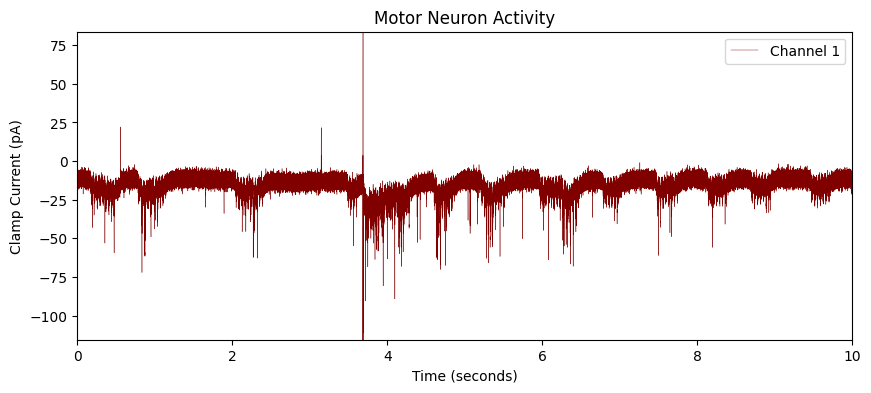

In [38]:
def get_std_range(array, stdnum=8):
    """
    Returns the lower and upper bounds of a region centered at the mean
    that contains the given percentage of the data, assuming a normal distribution.

    Returns:
    - (lower_bound, upper_bound)
    """
    mean = np.mean(array)
    std = np.std(array)

    lower = mean - stdnum * std
    upper = mean + stdnum * std
    return lower, upper

def plot_motorneuron_activity(abf):
    fig = plt.figure(figsize=(10, 4))
    # plot the first channel
    abf.setSweep(sweepNumber=4, channel=0)
    plt.plot(abf.sweepX, abf.sweepY, label="Channel 1",linewidth = 0.3,color='maroon')
    y_min, y_max = get_std_range(abf.sweepY,10)

    # decorate the plot
    plt.title("Motor Neuron Activity")
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.axis([0, 10, y_min, y_max]) # x bound, y bound
    plt.legend()
    plt.show()

plot_motorneuron_activity(abf)

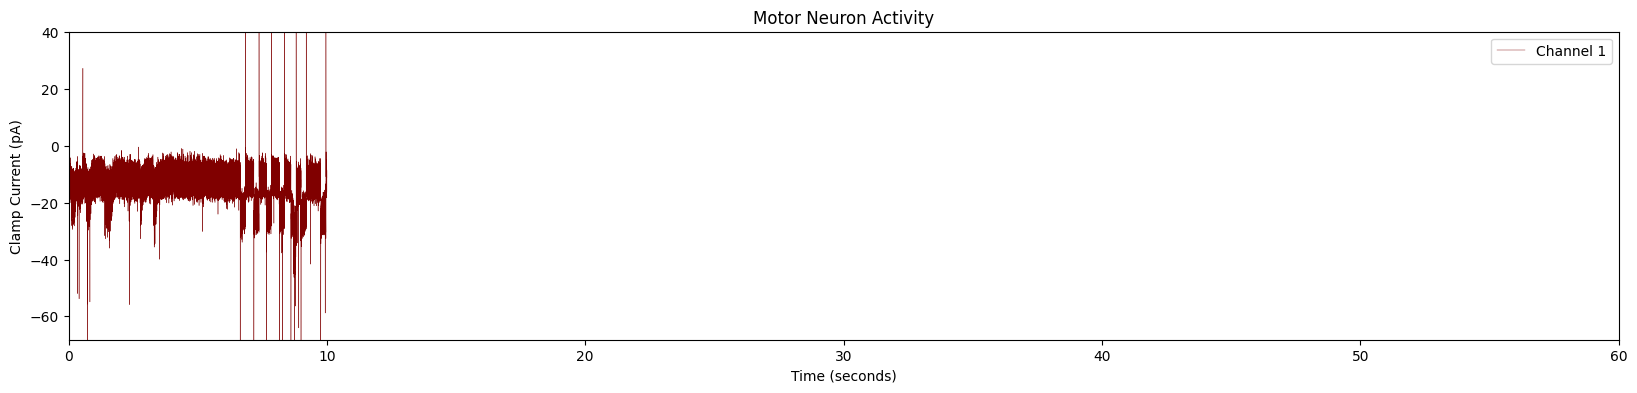

In [ ]:
def get_std_range(array, stdnum=8):
    """
    Returns the lower and upper bounds of a region centered at the mean
    that contains the given percentage of the data, assuming a normal distribution.

    Returns:
    - (lower_bound, upper_bound)
    """
    mean = np.mean(array)
    std = np.std(array)

    lower = mean - stdnum * std
    upper = mean + stdnum * std
    return lower, upper

def plot_motorneuron_activity(abf):
    fig = plt.figure(figsize=(20, 4))
    # plot the first channel
    abf.setSweep(sweepNumber=0, channel=0)
    plt.plot(abf.sweepX, abf.sweepY, label="Channel 1",linewidth = 0.3,color='maroon')
    y_min, y_max = get_std_range(abf.sweepY,10)

    # decorate the plot
    plt.title("Motor Neuron Activity")
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.axis([0, 60, y_min, y_max]) # x bound, y bound
    plt.legend()
    plt.show()

plot_motorneuron_activity(abf)

[ 0.  0.  0. ... 50. 50. 50.]


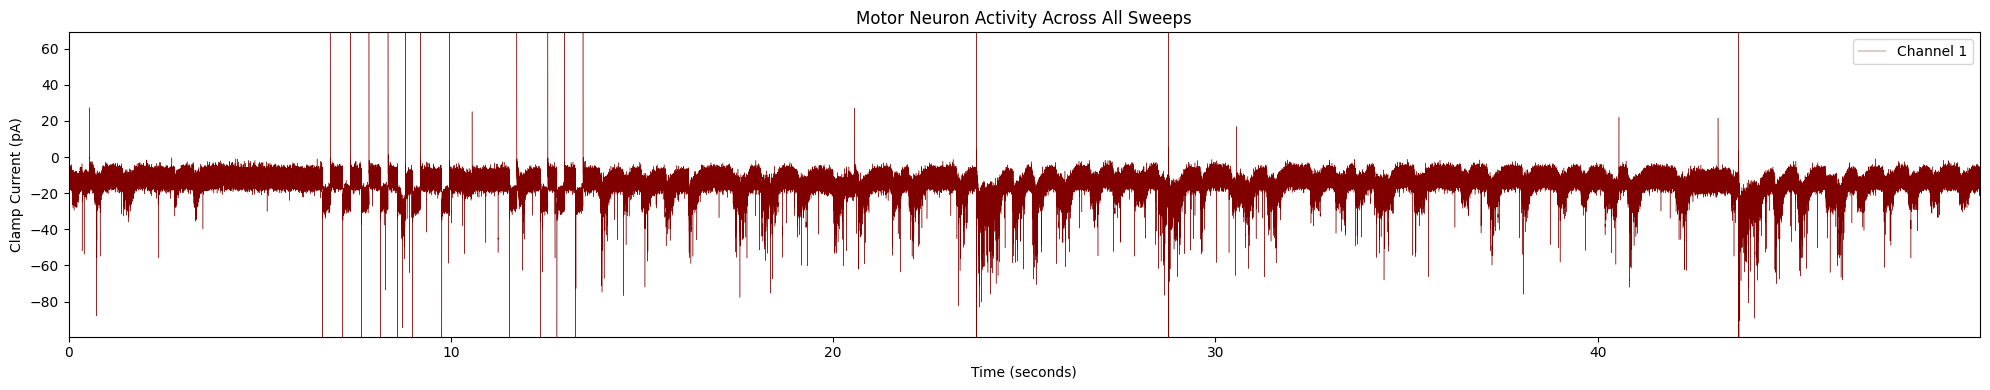

In [ ]:
def plot_motorneuron_activity_full(abf):
    all_times = []
    all_currents = []

    # Build full time series across all sweeps
    for sweep in range(abf.sweepCount):
        abf.setSweep(sweepNumber=sweep, channel=0)
        x = abf.sweepX + sweep * abf.sweepLengthSec  # global time
        y = abf.sweepY
        all_times.append(x)
        all_currents.append(y)
    # print(len(all_times))
    full_time = np.concatenate(all_times)
    print(full_time)

    full_current = np.concatenate(all_currents)

    y_min, y_max = get_std_range(full_current, 10)

    # Plotting
    plt.figure(figsize=(20, 4))
    plt.plot(full_time, full_current, label="Channel 1", linewidth=0.3, color='maroon')

    plt.title("Motor Neuron Activity Across All Sweeps")
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.axis([0, full_time[-1], y_min, y_max])
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_motorneuron_activity_full(abf)

In [ ]:
all_waveforms[(np.float64(32.61578604044627), 'Excitatory', 'CaP', 'primary')]

Time     Current     Phase  Normalized Current
2118859  21.18859 -207.946762  0.000000            0.509418
2118860  21.18860 -208.862289  0.000326            0.503276
2118861  21.18861 -210.327133  0.000652            0.493448
2118862  21.18862 -211.975082  0.000978            0.482391
2118863  21.18863 -213.745102  0.001305            0.470516
...           ...         ...       ...                 ...
2121921  21.21921 -220.642075  0.998695            0.424242
2121922  21.21922 -222.534164  0.999022            0.411548
2121923  21.21923 -223.510727  0.999348            0.404996
2121924  21.21924 -225.463852  0.999674            0.391892
2121925  21.21925 -226.501450  1.000000            0.384930

[3067 rows x 4 columns]

In [44]:
print(list(all_waveforms.keys())[:5])


[(np.float64(25.233409033558843), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(32.61578604044627), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(36.50967506389131), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(26.212319790300285), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(22.836263987212853), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0))]


Using Counter to count how many waveform trpes

In [77]:
from collections import Counter

def get_freq_bin(freq):
    if 15 <= freq < 25:
        return "15–25"
    elif 25 <= freq < 35:
        return "25–35"
    elif 35 <= freq < 45:
        return "35–45"
    elif freq >= 45:
        return "45+"
    else:
        return "<15"

def group_iSMN(cell_type):
    if cell_type in ["iSMN (dorsal) muscle", "iSMN"]:
        return "iSMN"
    return cell_type
key_counts = Counter()

for freq, signal_type,cell_type, cell,rin in all_waveforms.keys():
    freq_bin = get_freq_bin(freq)
    cell_type_gen = group_iSMN(cell_type)
    grouped_key = (freq_bin, signal_type, cell_type_gen, cell)
    key_counts[grouped_key] += 1

print(f"Unique waveform types: {len(key_counts)}\n")

Unique waveform types: 285



In [46]:
all_waveforms.keys()

dict_keys([(np.float64(25.233409033558843), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(32.61578604044627), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(36.50967506389131), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(26.212319790300285), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(22.836263987212853), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(27.21829069134327), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(28.137310073156204), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(1.0798319781442016), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(40.78303425775046), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(40.35512510088814), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(41.562759767250895), 'Excitatory', 'CaP', '2013_03_2

In [78]:
key_counts

Counter({('15–25', 'Cell-attached', 'MiP', '2013_03_21_cell4'): 681,
         ('25–35', 'Excitatory', 'vRoP', '2012_08_31_cell2'): 621,
         ('25–35', 'Cell-attached', 'vRoP', '2012_08_31_cell2'): 502,
         ('15–25', 'Cell-attached', 'CaP', '2013_03_22_cell2'): 427,
         ('25–35', 'Inhibitory', 'dSMN', '2012_08_31_cell4'): 417,
         ('15–25', 'Cell-attached', 'iSMN', '2012_12_06_cell4'): 320,
         ('25–35', 'Cell-attached', 'MiP', '2013_03_21_cell4'): 284,
         ('25–35', 'Cell-attached', 'dRoP', '2013_03_22_cell4'): 267,
         ('25–35', 'Inhibitory', 'vRoP', '2012_08_31_cell2'): 265,
         ('15–25', 'Cell-attached', 'CaP', '2013_03_22_cell1'): 256,
         ('25–35', 'Cell-attached', 'vSMN ', '2012_12_05_cell4'): 252,
         ('25–35', 'Cell-attached', 'MiP', '2013_03_21_cell1'): 226,
         ('15–25', 'Cell-attached', 'dRoP', '2013_03_22_cell4'): 212,
         ('25–35', 'Excitatory', 'iSMN', '2012_12_06_cell4'): 206,
         ('25–35', 'Inhibitory', 'vS

In [48]:
def bin_wave(onewave):
    # y_max = max(onewave["Current"])
    # y_min = min(onewave["Current"])
    # normalized = (onewave["Current"] - y_min) / (y_max - y_min)
    # onewave["Normalized Current"] = normalized
    # Make edges for the bin
    bins = np.linspace(0, 1, 51, endpoint = True)

    # Cut the phase into bins
    onewave['Phase Bin'] = pd.cut(onewave['Phase'], bins=bins, include_lowest=True)
    # print(onewave)

    # Group by the bins and calculate the average current
    # binned_avg = onewave.groupby(by='Phase Bin','Current')
    binned_avg = onewave.groupby('Phase Bin',observed=True)[['Current','Normalized Current']].mean().reset_index()
    # print(binned_avg)

    # Get phase column for plotting (middle of bin)
    phase = np.arange(0.01, 1.00001, 0.02)
    # len(phase)
    binned_avg['Phase'] = phase
    return binned_avg

In [52]:
onekey = list(all_waveforms.keys())[0]
bin_table = bin_wave(all_waveforms[onekey])
bin_table

Phase Bin     Current  Normalized Current  Phase
0   (-0.001, 0.02] -599.745850            0.267700   0.01
1     (0.02, 0.04] -601.768738            0.264329   0.03
2     (0.04, 0.06] -627.578674            0.221315   0.05
3     (0.06, 0.08] -623.532043            0.228059   0.07
4      (0.08, 0.1] -672.064819            0.147176   0.09
5      (0.1, 0.12] -664.501587            0.159781   0.11
6     (0.12, 0.14] -595.503784            0.274770   0.13
7     (0.14, 0.16] -688.802063            0.119283   0.15
8     (0.16, 0.18] -699.344116            0.101713   0.17
9      (0.18, 0.2] -714.166077            0.077012   0.19
10     (0.2, 0.22] -687.889709            0.120803   0.21
11    (0.22, 0.24] -496.318787            0.440068   0.23
12    (0.24, 0.26] -386.526367            0.623045   0.25
13    (0.26, 0.28] -376.879700            0.639121   0.27
14     (0.28, 0.3] -313.906097            0.744071   0.29
15     (0.3, 0.32] -253.166183            0.845298   0.31
16    (0.32, 0.34] -224.646439            0.892828   0.33
17    (0.34, 0.36] -206.340530            0.923336   0.35
18    (0.36, 0.38] -189.737427            0.951006   0.37
19     (0.38, 0.4] -177.361282            0.971632   0.39
20     (0.4, 0.42] -174.121704            0.977031   0.41
21    (0.42, 0.44] -178.818314            0.969204   0.43
22    (0.44, 0.46] -169.707840            0.984387   0.45
23    (0.46, 0.48] -174.242386            0.976830   0.47
24     (0.48, 0.5] -185.991104            0.957250   0.49
25     (0.5, 0.52] -201.521835            0.931367   0.51
26    (0.52, 0.54] -192.410263            0.946552   0.53
27    (0.54, 0.56] -175.415024            0.974875   0.55
28    (0.56, 0.58] -191.916916            0.947374   0.57
29     (0.58, 0.6] -181.662247            0.964464   0.59
30     (0.6, 0.62] -172.597488            0.979571   0.61
31    (0.62, 0.64] -172.686218            0.979423   0.63
32    (0.64, 0.66] -204.380447            0.926603   0.65
33    (0.66, 0.68] -179.111130            0.968716   0.67
34     (0.68, 0.7] -191.519913            0.948036   0.69
35     (0.7, 0.72] -184.725586            0.959359   0.71
36    (0.72, 0.74] -180.884232            0.965761   0.73
37    (0.74, 0.76] -195.844040            0.940829   0.75
38    (0.76, 0.78] -206.841263            0.922502   0.77
39     (0.78, 0.8] -249.999969            0.850575   0.79
40     (0.8, 0.82] -225.330200            0.891688   0.81
41    (0.82, 0.84] -216.128555            0.907024   0.83
42    (0.84, 0.86] -213.791656            0.910918   0.85
43    (0.86, 0.88] -203.997238            0.927241   0.87
44     (0.88, 0.9] -195.698792            0.941071   0.89
45     (0.9, 0.92] -202.330765            0.930019   0.91
46    (0.92, 0.94] -196.102127            0.940399   0.93
47    (0.94, 0.96] -194.007568            0.943890   0.95
48    (0.96, 0.98] -198.114685            0.937045   0.97
49     (0.98, 1.0] -211.801117            0.914236   0.99

<Axes: xlabel='Phase'>

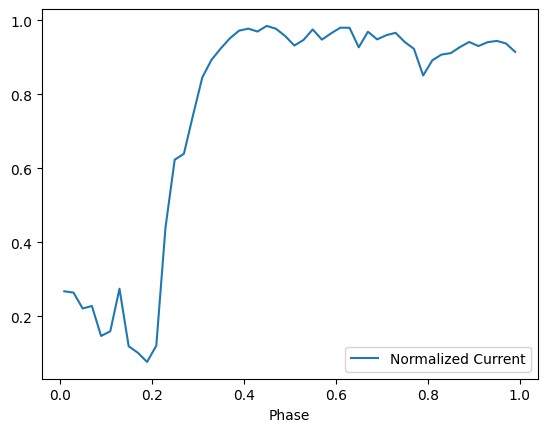

In [53]:
bin_table.plot("Phase","Normalized Current")

bin `all_waveforms` and store in `binned_waveforms`

In [79]:
def bin_wave(onewave):
    """
    Bins the waveform into 50 phase bins from 0 to 1.
    Skips waveforms that do not contain data in all bins.
    Returns a binned average dataframe or None.
    """
    bins = np.linspace(0, 1, 51, endpoint=True)

    # Cut the phase into bins
    onewave['Phase Bin'] = pd.cut(onewave['Phase'], bins=bins, include_lowest=True)

    # Group by the bins and calculate the average current
    binned_avg = onewave.groupby('Phase Bin', observed=True)[['Current', 'Normalized Current']].mean().reset_index()

    if len(binned_avg) != 50:
        print(f"⚠️ Skipping waveform: only {len(binned_avg)} bins present (expected 50)")
        return None

    # Assign Phase column as center of bins
    phase = np.arange(0.01, 1.00001, 0.02)
    binned_avg['Phase'] = phase

    return binned_avg


In [83]:
def bin_wave(onewave):
    """
    Bins the waveform into 50 fixed phase bins from 0 to 1.
    Fills missing bins with NaNs instead of skipping the waveform.
    Returns a DataFrame with mean current per phase bin.
    """
    # Define bins and bin centers
    bins = np.linspace(0, 1, 51, endpoint=True)
    phase = np.arange(0.01, 1.00001, 0.02)

    # Bin the phase
    onewave['Phase Bin'] = pd.cut(onewave['Phase'], bins=bins, include_lowest=True)

    # Group by bin and compute mean values
    binned_avg = onewave.groupby('Phase Bin', observed=True)[['Current', 'Normalized Current']].mean()

    # Create a reference DataFrame with all bin labels
    full_bins = pd.cut(phase, bins=bins, include_lowest=True)
    full_df = pd.DataFrame({'Phase Bin': full_bins, 'Phase': phase})

    # Merge to ensure all bins are present, missing ones get NaN
    binned_avg = full_df.merge(binned_avg, on='Phase Bin', how='left')

    return binned_avg


In [84]:
binned_waveforms = {}
for wave in all_waveforms.keys():
    binned = bin_wave(all_waveforms[wave])
    binned_waveforms[wave] = binned

In [85]:
len(binned_waveforms)

15310

In [67]:
onewv

(np.float64(27.21829069134327),
 'Excitatory',
 'CaP',
 '2013_03_21_cell5',
 np.float64(33.0))

In [86]:
onewv=list(binned_waveforms.keys())[5]
binned_waveforms[onewv]

Phase Bin  Phase     Current  Normalized Current
0   (-0.001, 0.02]   0.01 -113.217735            0.475493
1     (0.02, 0.04]   0.03 -114.088081            0.446272
2     (0.04, 0.06]   0.05 -111.842789            0.521655
3     (0.06, 0.08]   0.07 -111.740318            0.525095
4      (0.08, 0.1]   0.09 -112.217247            0.509083
5      (0.1, 0.12]   0.11 -111.499519            0.533180
6     (0.12, 0.14]   0.13 -113.182259            0.476684
7     (0.14, 0.16]   0.15 -115.926651            0.384544
8     (0.16, 0.18]   0.17 -115.986580            0.382532
9      (0.18, 0.2]   0.19 -115.941704            0.384039
10     (0.2, 0.22]   0.21 -114.533279            0.431325
11    (0.22, 0.24]   0.23 -116.496040            0.365428
12    (0.24, 0.26]   0.25 -121.417892            0.200183
13    (0.26, 0.28]   0.27 -116.829636            0.354227
14     (0.28, 0.3]   0.29 -114.346878            0.437583
15     (0.3, 0.32]   0.31 -112.402504            0.502863
16    (0.32, 0.34]   0.33 -113.275467            0.473555
17    (0.34, 0.36]   0.35 -113.522034            0.465276
18    (0.36, 0.38]   0.37 -119.974762            0.248634
19     (0.38, 0.4]   0.39 -118.380096            0.302173
20     (0.4, 0.42]   0.41 -119.929955            0.250138
21    (0.42, 0.44]   0.43 -117.807869            0.321384
22    (0.44, 0.46]   0.45 -113.640030            0.461315
23    (0.46, 0.48]   0.47 -110.781311            0.557293
24     (0.48, 0.5]   0.49 -110.315262            0.572940
25     (0.5, 0.52]   0.51 -109.473656            0.601196
26    (0.52, 0.54]   0.53 -108.536385            0.632663
27    (0.54, 0.56]   0.55 -108.417404            0.636658
28    (0.56, 0.58]   0.57 -107.612495            0.663682
29     (0.58, 0.6]   0.59 -105.305435            0.741139
30     (0.6, 0.62]   0.61 -109.583183            0.597519
31    (0.62, 0.64]   0.63 -107.321243            0.673460
32    (0.64, 0.66]   0.65 -104.614250            0.764344
33    (0.66, 0.68]   0.67 -102.141502            0.847364
34     (0.68, 0.7]   0.69 -106.345810            0.706209
35     (0.7, 0.72]   0.71 -117.949989            0.316613
36    (0.72, 0.74]   0.73 -107.014687            0.683752
37    (0.74, 0.76]   0.75 -103.967606            0.786054
38    (0.76, 0.78]   0.77 -103.252251            0.810072
39     (0.78, 0.8]   0.79 -105.707932            0.727625
40     (0.8, 0.82]   0.81 -110.124138            0.579357
41    (0.82, 0.84]   0.83 -105.199860            0.744683
42    (0.84, 0.86]   0.85 -113.353981            0.470918
43    (0.86, 0.88]   0.87 -108.615356            0.630012
44     (0.88, 0.9]   0.89 -104.479637            0.768864
45     (0.9, 0.92]   0.91 -104.027817            0.784033
46    (0.92, 0.94]   0.93 -103.651901            0.796654
47    (0.94, 0.96]   0.95 -109.943283            0.585429
48    (0.96, 0.98]   0.97 -118.126564            0.310685
49     (0.98, 1.0]   0.99 -114.783203            0.422934

Save binned waveforms dict using pickle

In [87]:
import pickle
# Save it to a file
with open("binwvsrin_oldNaNs.pkl", "wb") as f:
    pickle.dump(binned_waveforms, f)

print("Saved to binwvsrin_oldNaNs.pkl")


Saved to binwvsrin_oldNaNs.pkl


NEXT: access keys to average across the key types and plot
- current type: excitatory, inhibitory, cell-attached
- frequency bins: 15-25,25-35,35-45,45+
- rin: low/mid/high or fast/slow (for now sort by motoneuron class)
- cell type: CaP,vRoP,MiP,dRoP,dVS,dSMN,vSMN,iSMN

function(current,freq,rin,type) -> plot waveform

In [66]:
binned_waveforms.keys()

dict_keys([(np.float64(25.233409033558843), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(32.61578604044627), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(36.50967506389131), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(26.212319790300285), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(22.836263987212853), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(27.21829069134327), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(28.137310073156204), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(1.0798319781442016), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(40.78303425775046), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(40.35512510088814), 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)), (np.float64(41.562759767250895), 'Excitatory', 'CaP', '2013_03_2

In [69]:
def average_waveforms_for_key(counter_key):
    '''
    Function that takes a counter key like ('15–25', 'Cell-attached', 'MiP', 'primary')
    Returns df of averaged waveform for that key
    '''
    #Separate key code
    freq_bin, signal_type,cell_type, cell = counter_key
    
    dfs = [] # To store matching waveforms dataframes
    # loop through all binned waveforms
    for key in binned_waveforms.keys():
        freq, st,ct, cl,rn = key
        # use get_freq_bin(freq) to turn float into bin, use group_iSMN() to generalize all iSMN
        if get_freq_bin(freq) == freq_bin and ct == group_iSMN(cell_type) and st == signal_type and cl==cell:
            dfs.append(binned_waveforms[key].copy())
    # if no waveforms for key
    if not dfs:
        print(f"No matching waveforms found for {counter_key}")
        return None
    # combine all the data frames
    # print(len(dfs))
    combined = pd.concat(dfs)
    # print(combined.shape)
    averaged = combined.groupby('Phase Bin', observed=False).mean().reset_index()
    return averaged

In [ ]:
986*50

49300

In [70]:
avg_table = average_waveforms_for_key(('15–25', 'Excitatory', 'CaP','2013_03_21_cell5'))
avg_table.shape

(50, 4)

In [71]:
key_counts

Counter({('15–25',
          'Cell-attached',
          'MiP',
          '2013_03_21_cell4',
          np.float64(47.15)): 681,
         ('25–35',
          'Excitatory',
          'vRoP',
          '2012_08_31_cell2',
          np.float64(44.77)): 621,
         ('25–35',
          'Cell-attached',
          'vRoP',
          '2012_08_31_cell2',
          np.float64(44.77)): 502,
         ('15–25',
          'Cell-attached',
          'CaP',
          '2013_03_22_cell2',
          np.float64(43.64)): 427,
         ('25–35',
          'Inhibitory',
          'dSMN',
          '2012_08_31_cell4',
          np.float64(242.57)): 417,
         ('15–25',
          'Cell-attached',
          'iSMN',
          '2012_12_06_cell4',
          np.float64(861.9)): 320,
         ('25–35',
          'Cell-attached',
          'MiP',
          '2013_03_21_cell4',
          np.float64(47.15)): 284,
         ('25–35',
          'Cell-attached',
          'dRoP',
          '2013_03_22_cell4',
          n

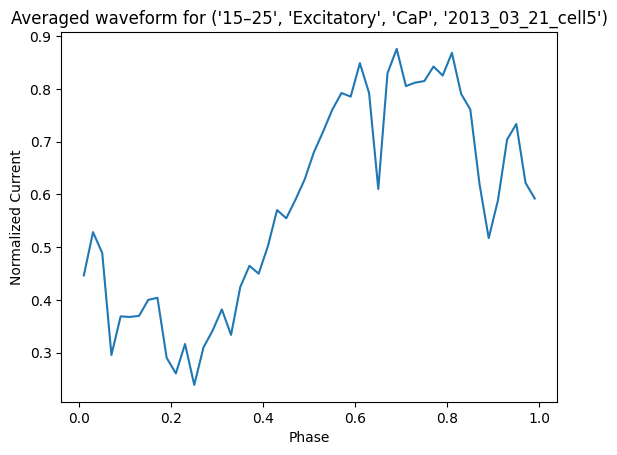

In [73]:
# Use a key from Counter
example_key = ('15–25', 'Excitatory', 'CaP','2013_03_21_cell5')

avg_waveform_df = average_waveforms_for_key(example_key)

if avg_waveform_df is not None:
    plt.plot(avg_waveform_df['Phase'], avg_waveform_df['Normalized Current'])
    plt.xlabel('Phase')
    plt.ylabel('Normalized Current')
    plt.title(f'Averaged waveform for {example_key}')
    plt.show()


In [75]:
key_counts

Counter({('15–25',
          'Cell-attached',
          'MiP',
          '2013_03_21_cell4',
          np.float64(47.15)): 681,
         ('25–35',
          'Excitatory',
          'vRoP',
          '2012_08_31_cell2',
          np.float64(44.77)): 621,
         ('25–35',
          'Cell-attached',
          'vRoP',
          '2012_08_31_cell2',
          np.float64(44.77)): 502,
         ('15–25',
          'Cell-attached',
          'CaP',
          '2013_03_22_cell2',
          np.float64(43.64)): 427,
         ('25–35',
          'Inhibitory',
          'dSMN',
          '2012_08_31_cell4',
          np.float64(242.57)): 417,
         ('15–25',
          'Cell-attached',
          'iSMN',
          '2012_12_06_cell4',
          np.float64(861.9)): 320,
         ('25–35',
          'Cell-attached',
          'MiP',
          '2013_03_21_cell4',
          np.float64(47.15)): 284,
         ('25–35',
          'Cell-attached',
          'dRoP',
          '2013_03_22_cell4',
          n

Skipping ('25–35', 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)) due to error: too many values to unpack (expected 4)
Skipping ('35–45', 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)) due to error: too many values to unpack (expected 4)
Skipping ('15–25', 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)) due to error: too many values to unpack (expected 4)
Skipping ('<15', 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)) due to error: too many values to unpack (expected 4)
Skipping ('45+', 'Excitatory', 'CaP', '2013_03_21_cell5', np.float64(33.0)) due to error: too many values to unpack (expected 4)
Skipping ('25–35', 'Cell-attached', 'CaP', '2013_03_21_cell5', np.float64(33.0)) due to error: too many values to unpack (expected 4)
Skipping ('<15', 'Cell-attached', 'CaP', '2013_03_21_cell5', np.float64(33.0)) due to error: too many values to unpack (expected 4)
Skipping ('35–45', 'Cell-attached', 'CaP', '2013_03_21_cell5', np.float64(33.0)) du

/var/folders/mw/pz4gm95j6zb7syl48vm11wrw0000gn/T/ipykernel_20581/1820168028.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


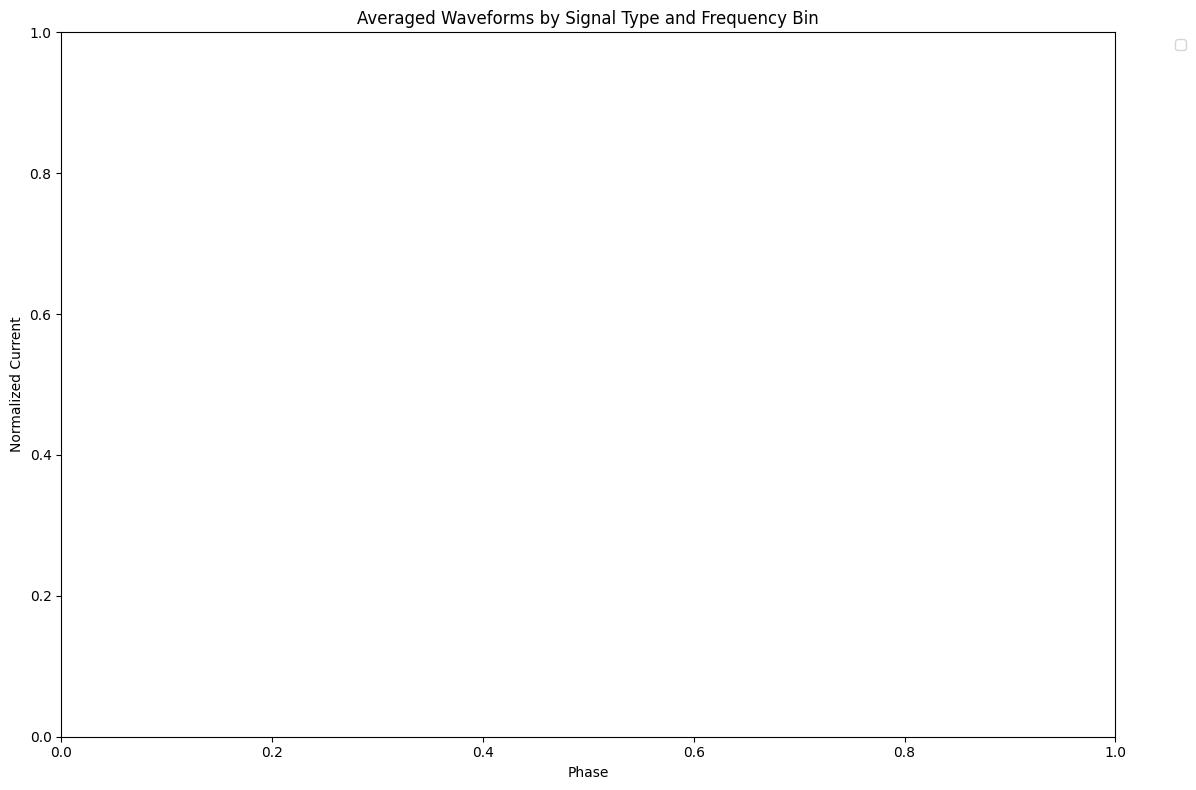

In [74]:
plt.figure(figsize=(12, 8))

for key in key_counts:
    try:
        avg_waveform_df = average_waveforms_for_key(key)
        if avg_waveform_df is None or avg_waveform_df.empty:
            print(f"Skipping: No data for {key}")
            continue
        label = f"{key[1]} | {key[0]}Hz | {key[2]} | {key[3]}"
        plt.plot(avg_waveform_df['Phase'], avg_waveform_df['Normalized Current'], label=label)
    except Exception as e:
        print(f"Skipping {key} due to error: {e}")
        continue

plt.xlabel('Phase')
plt.ylabel('Normalized Current')
plt.title('Averaged Waveforms by Signal Type and Frequency Bin')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/mw/pz4gm95j6zb7syl48vm11wrw0000gn/T/ipykernel_14480/3802899614.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(signal_types))  # or use 'Set1', 'tab20', etc.


Plotting waveforms for swimming speed: primary


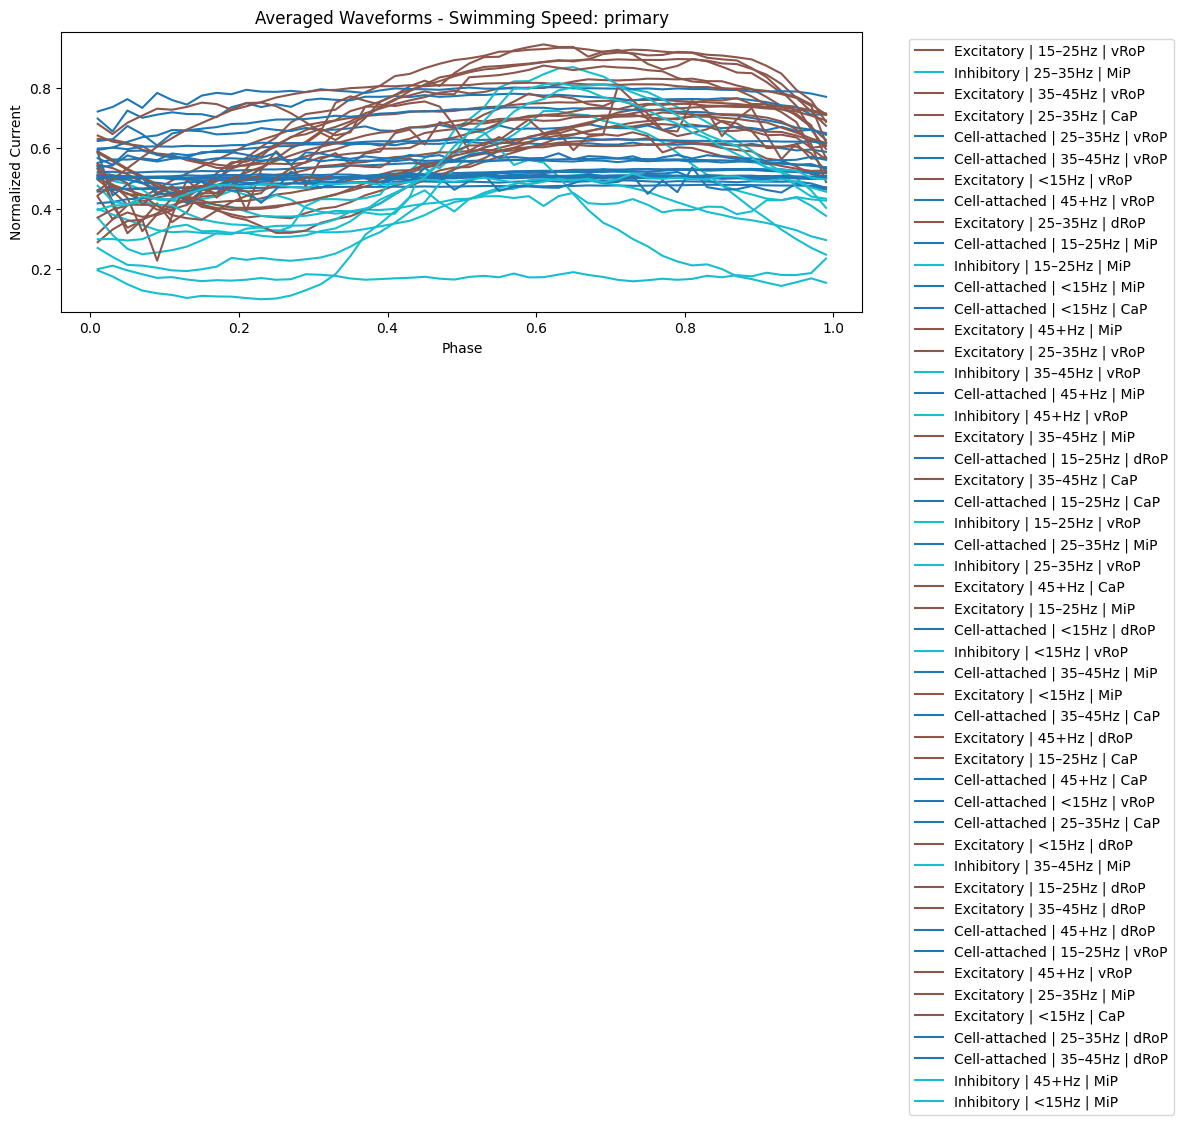

Plotting waveforms for swimming speed: Low Rin Secondary 


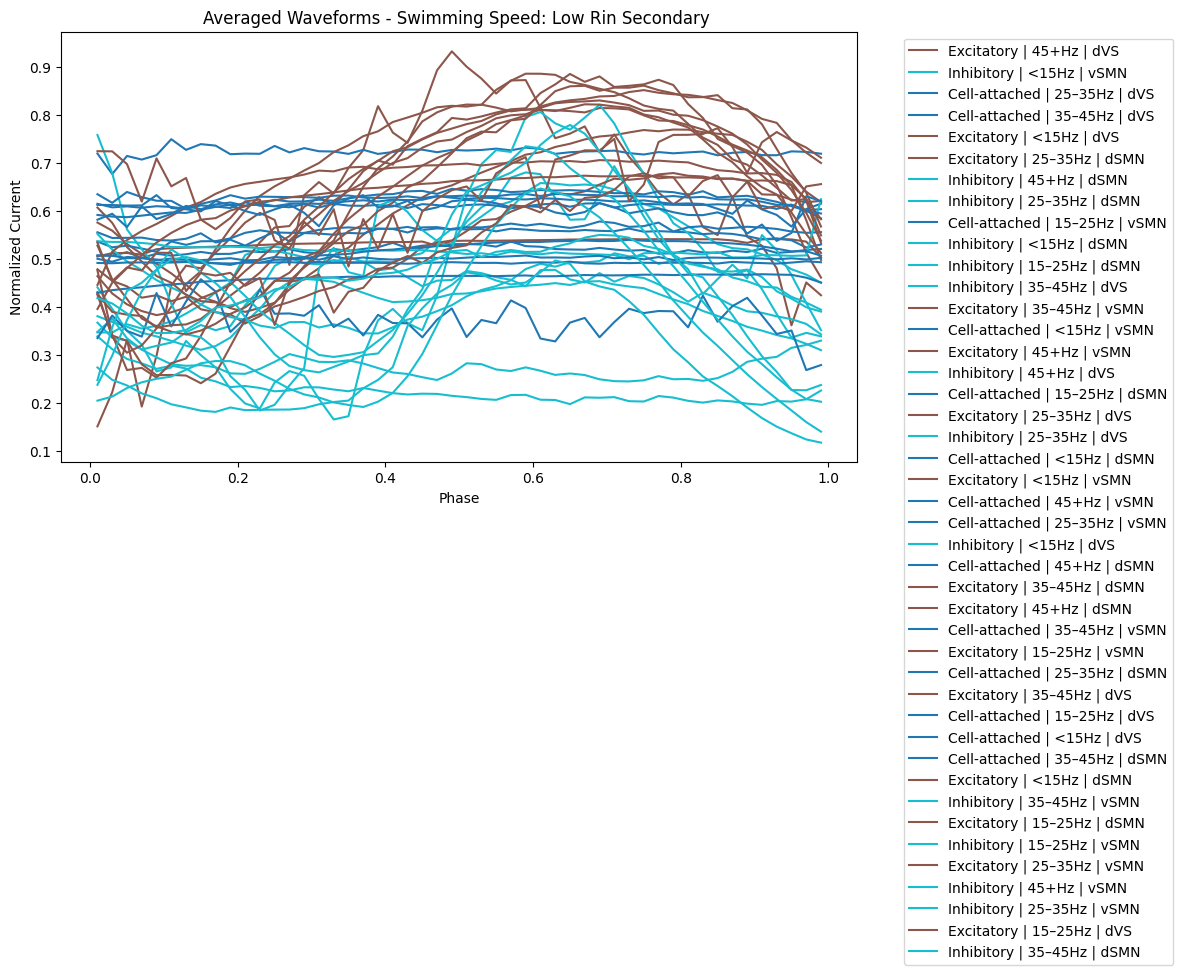

Plotting waveforms for swimming speed: High Rin Secondary
No matching waveforms found for ('35–45', 'Inhibitory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('35–45', 'Inhibitory', 'iSMN', 'High Rin Secondary')
No matching waveforms found for ('25–35', 'Excitatory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('25–35', 'Excitatory', 'iSMN', 'High Rin Secondary')
No matching waveforms found for ('15–25', 'Inhibitory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('15–25', 'Inhibitory', 'iSMN', 'High Rin Secondary')
No matching waveforms found for ('25–35', 'Inhibitory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('25–35', 'Inhibitory', 'iSMN', 'High Rin Secondary')
No matching waveforms found for ('45+', 'Inhibitory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('45+', 'Inhibitory', 'iSMN', 'High Rin Secondary')
No matching waveforms found for ('<15', 'Inhibitory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('<15', 'Inhibitor

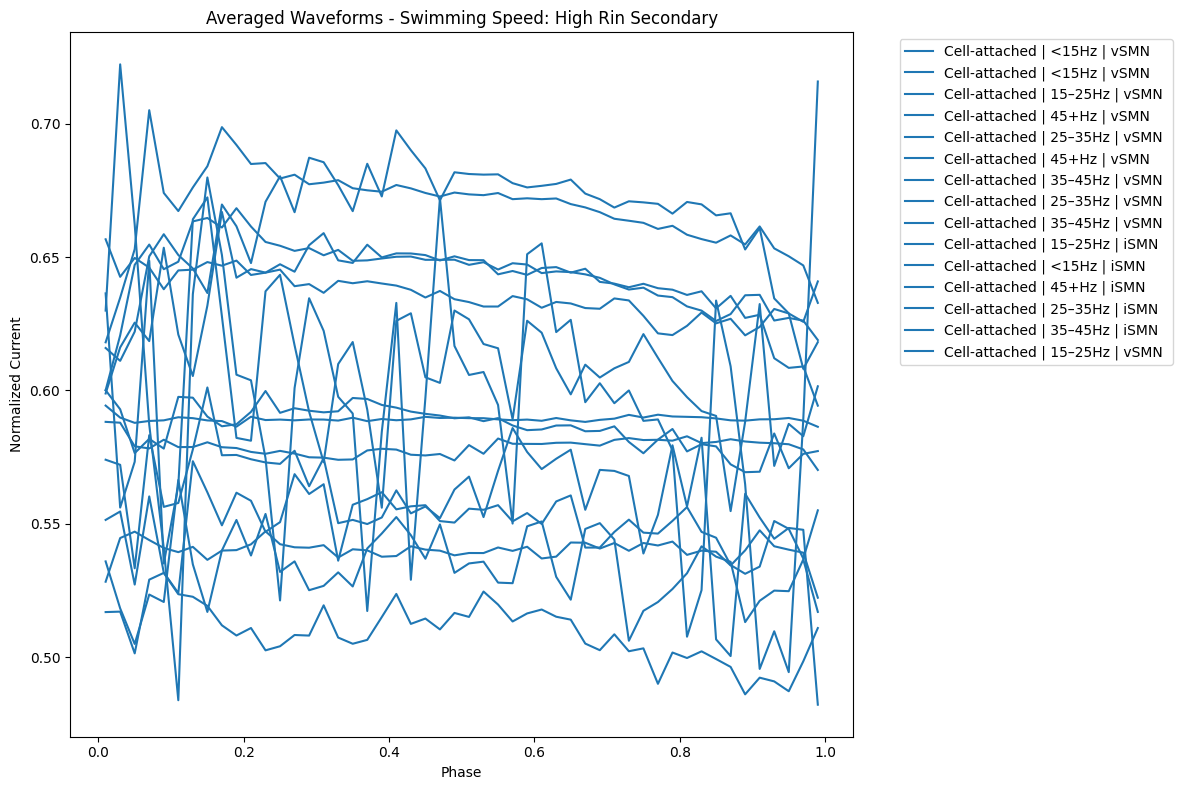

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Step 1: Group waveform keys by fast_slow (swimming speed)
waveforms_by_speed = defaultdict(list)
signal_types = set()

for freq, signal_type, cell_type, fast_slow in all_waveforms.keys():
    freq_bin = get_freq_bin(freq)
    cell_type_gen = group_iSMN(cell_type)
    grouped_key = (freq_bin, signal_type, cell_type_gen, fast_slow)
    waveforms_by_speed[fast_slow].append(grouped_key)
    signal_types.add(signal_type)

# Step 2: Assign a unique color to each signal type
cmap = cm.get_cmap('tab10', len(signal_types))  # or use 'Set1', 'tab20', etc.
signal_type_colors = {stype: cmap(i) for i, stype in enumerate(sorted(signal_types))}

# Step 3: Plot one figure per swimming speed, with color coding by signal type
for speed_category, keys in waveforms_by_speed.items():
    plt.figure(figsize=(12, 8))
    print(f"Plotting waveforms for swimming speed: {speed_category}")

    plotted_any = False
    for key in set(keys):
        try:
            avg_waveform_df = average_waveforms_for_key(key)
            if avg_waveform_df is None or avg_waveform_df.empty:
                print(f"  Skipping: No data for {key}")
                continue

            signal_type = key[1]
            color = signal_type_colors.get(signal_type, 'gray')  # default to gray if missing
            label = f"{signal_type} | {key[0]}Hz | {key[2]}"
            plt.plot(avg_waveform_df['Phase'], avg_waveform_df['Normalized Current'],
                     label=label, color=color)
            plotted_any = True
        except Exception as e:
            print(f"  Error with {key}: {e}")
            continue

    if plotted_any:
        plt.xlabel('Phase')
        plt.ylabel('Normalized Current')
        plt.title(f'Averaged Waveforms - Swimming Speed: {speed_category}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print(f"  No valid waveforms to plot for {speed_category}")


Plotting waveforms for frequency bin '15–25' and swimming speed 'High Rin Secondary'
No matching waveforms found for ('15–25', 'Excitatory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('15–25', 'Excitatory', 'iSMN', 'High Rin Secondary')
No matching waveforms found for ('15–25', 'Inhibitory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('15–25', 'Inhibitory', 'iSMN', 'High Rin Secondary')


/var/folders/mw/pz4gm95j6zb7syl48vm11wrw0000gn/T/ipykernel_14480/2164276240.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(signal_types))  # or use 'Set1', 'tab20', etc.


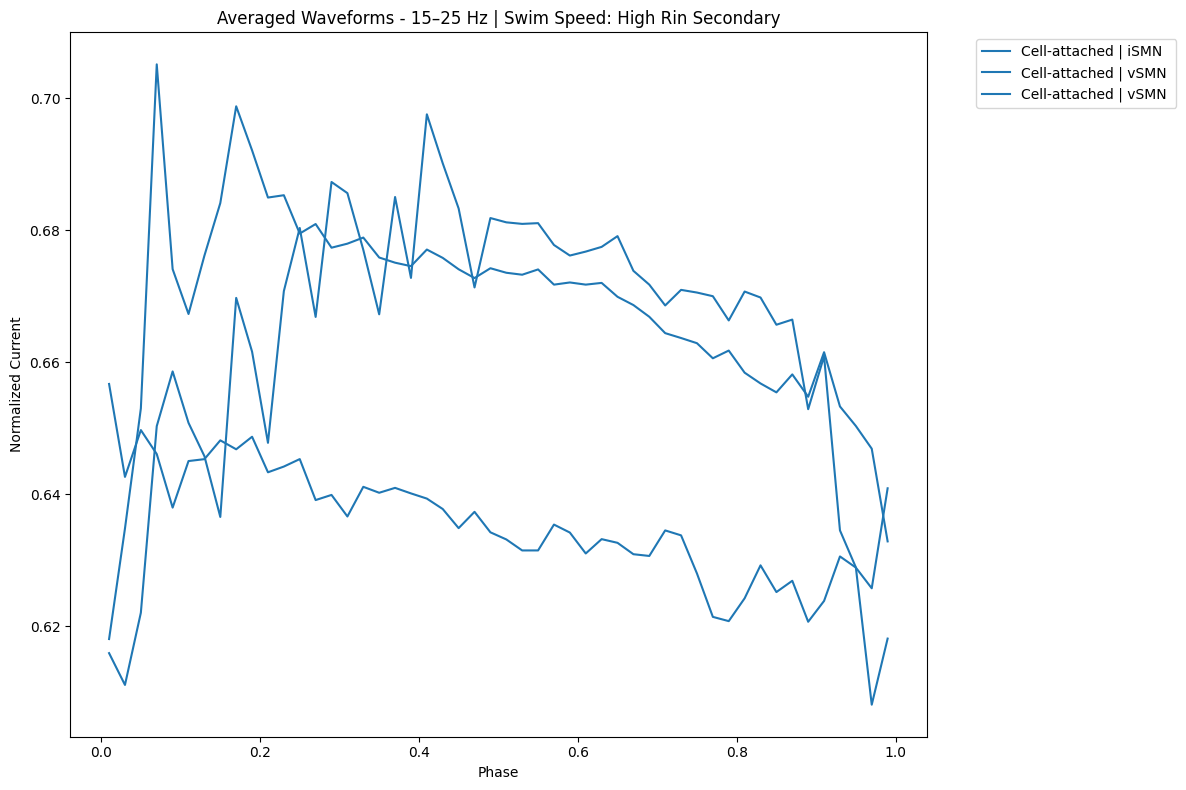

Plotting waveforms for frequency bin '15–25' and swimming speed 'Low Rin Secondary '


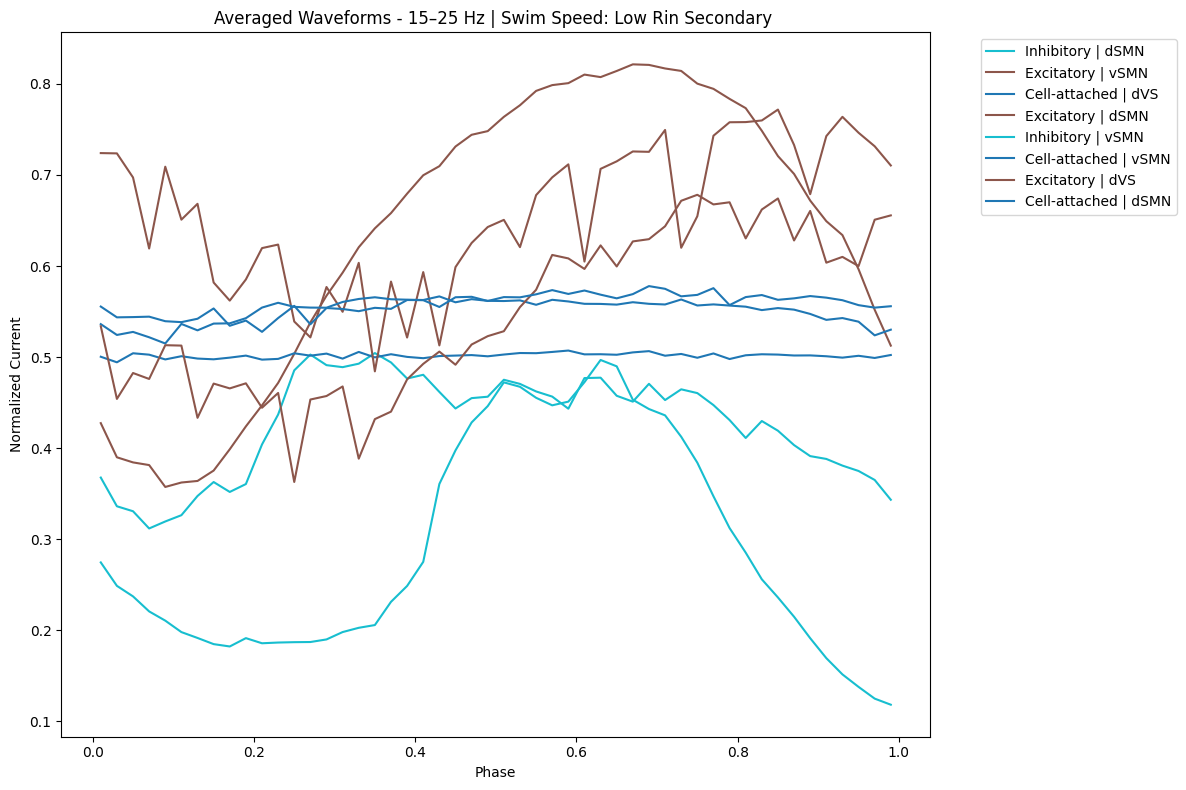

Plotting waveforms for frequency bin '15–25' and swimming speed 'primary'


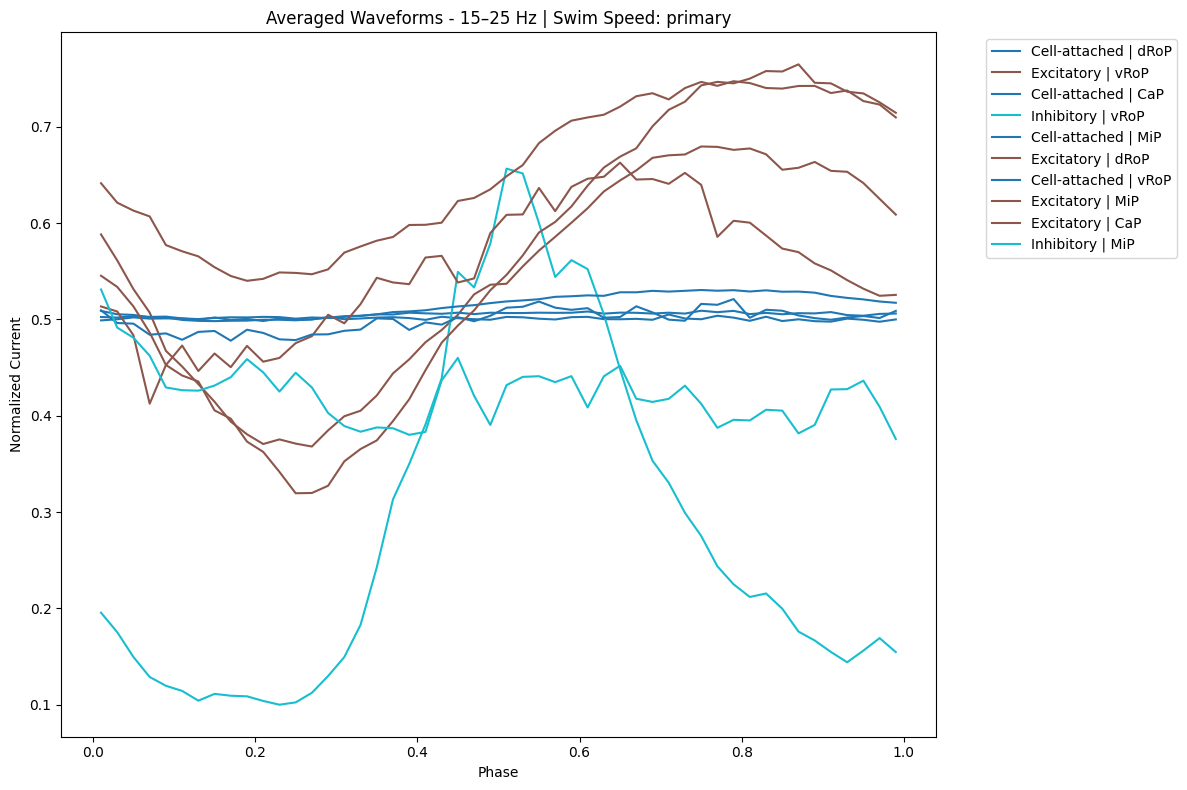

Plotting waveforms for frequency bin '25–35' and swimming speed 'High Rin Secondary'
No matching waveforms found for ('25–35', 'Excitatory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('25–35', 'Excitatory', 'iSMN', 'High Rin Secondary')
No matching waveforms found for ('25–35', 'Inhibitory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('25–35', 'Inhibitory', 'iSMN', 'High Rin Secondary')


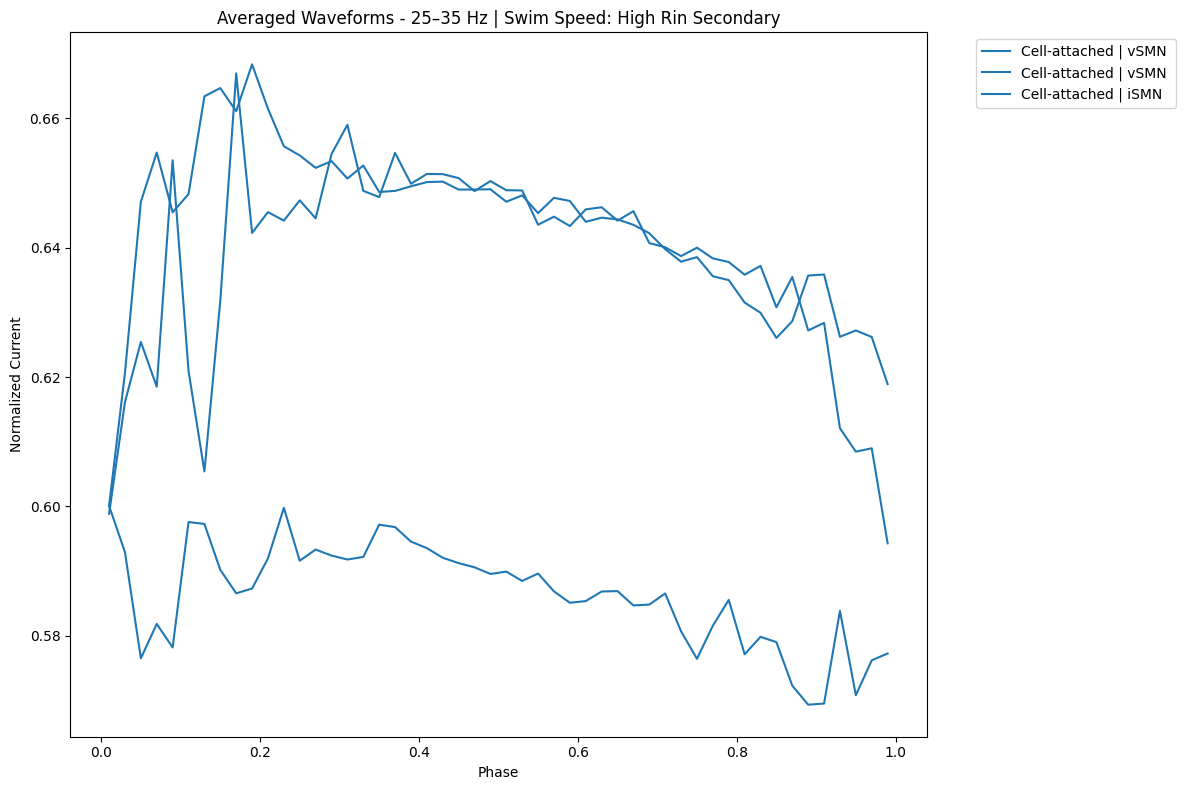

Plotting waveforms for frequency bin '25–35' and swimming speed 'Low Rin Secondary '


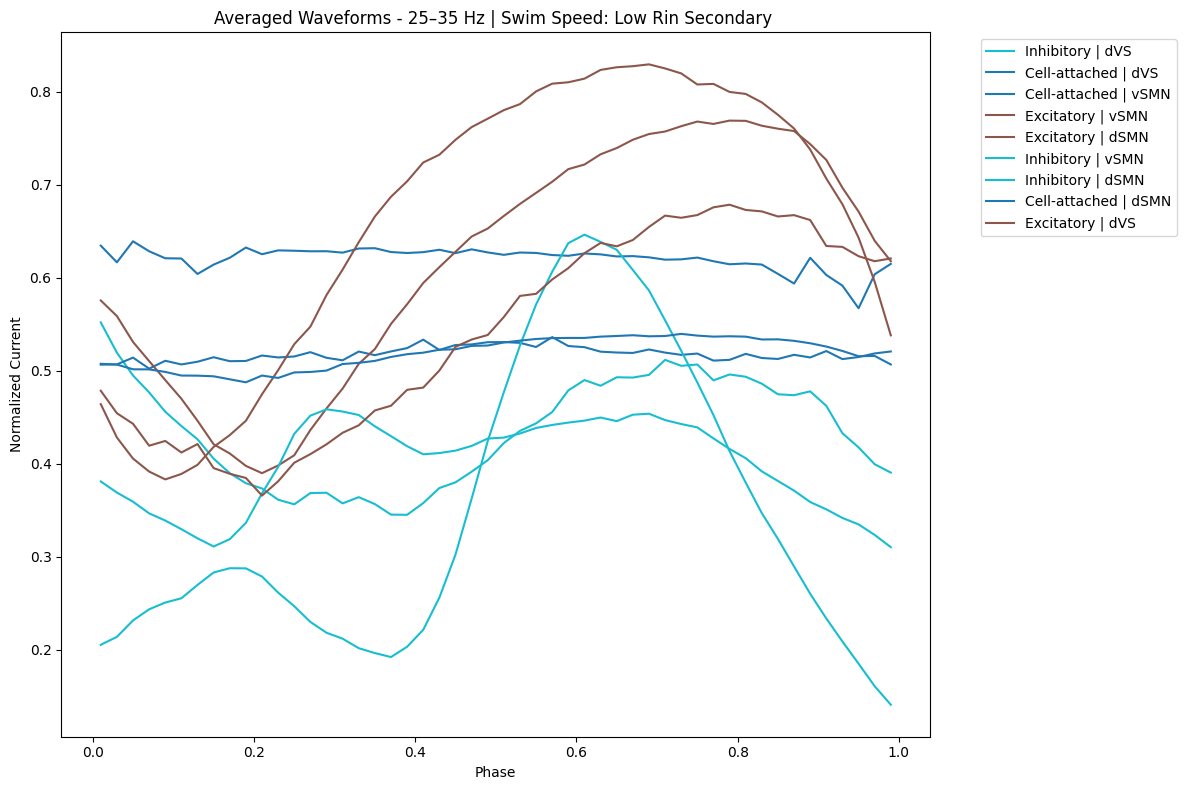

Plotting waveforms for frequency bin '25–35' and swimming speed 'primary'


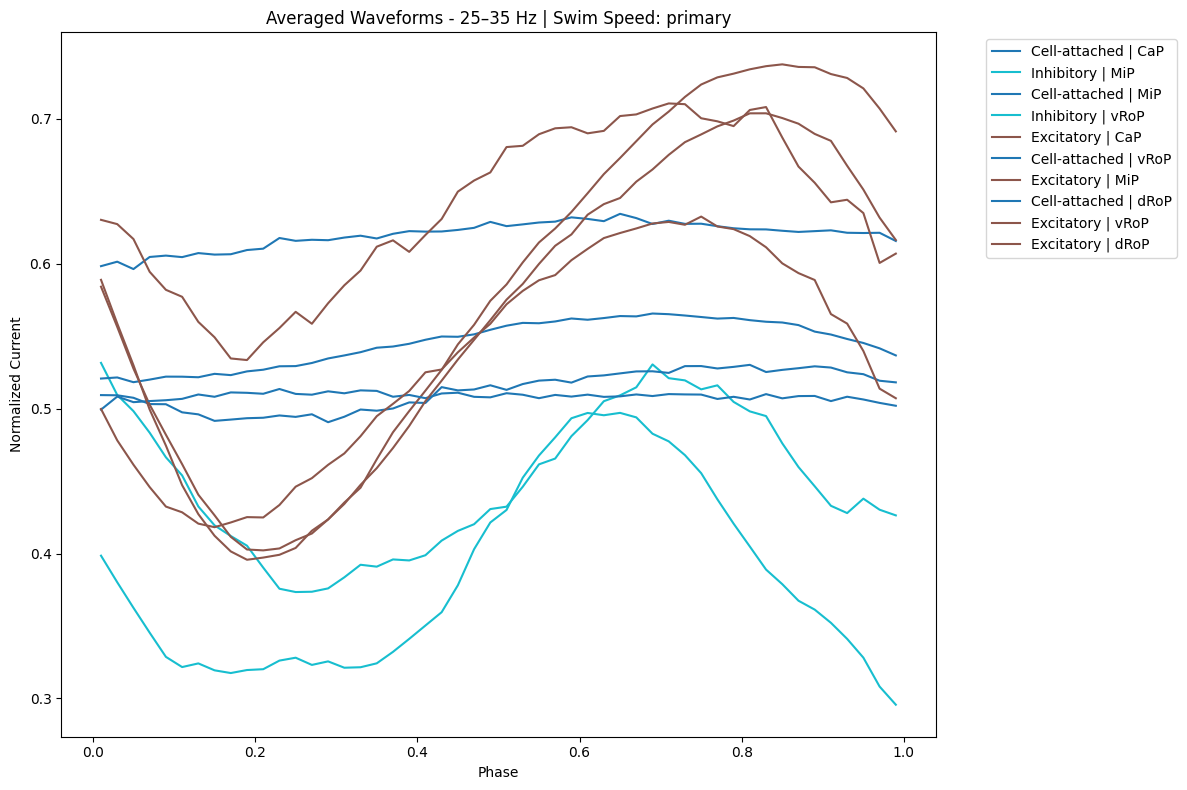

Plotting waveforms for frequency bin '35–45' and swimming speed 'High Rin Secondary'
No matching waveforms found for ('35–45', 'Inhibitory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('35–45', 'Inhibitory', 'iSMN', 'High Rin Secondary')
No matching waveforms found for ('35–45', 'Excitatory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('35–45', 'Excitatory', 'iSMN', 'High Rin Secondary')


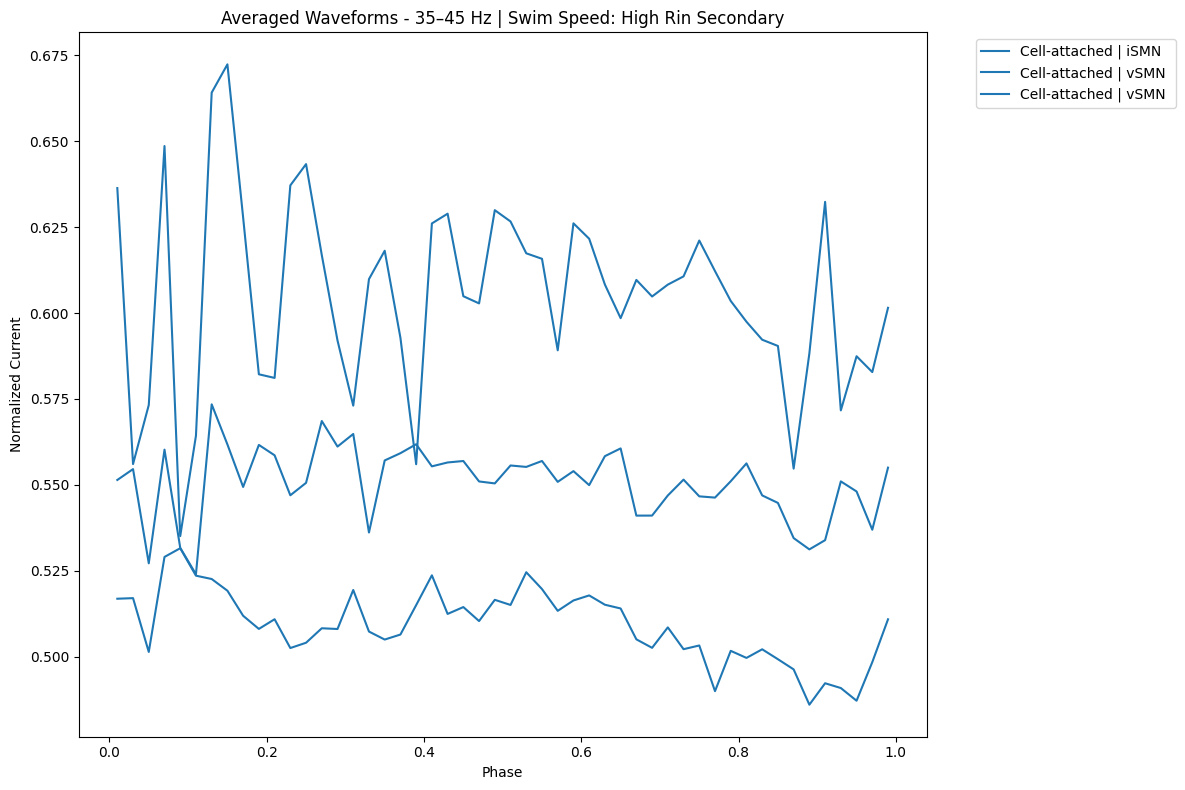

Plotting waveforms for frequency bin '35–45' and swimming speed 'Low Rin Secondary '


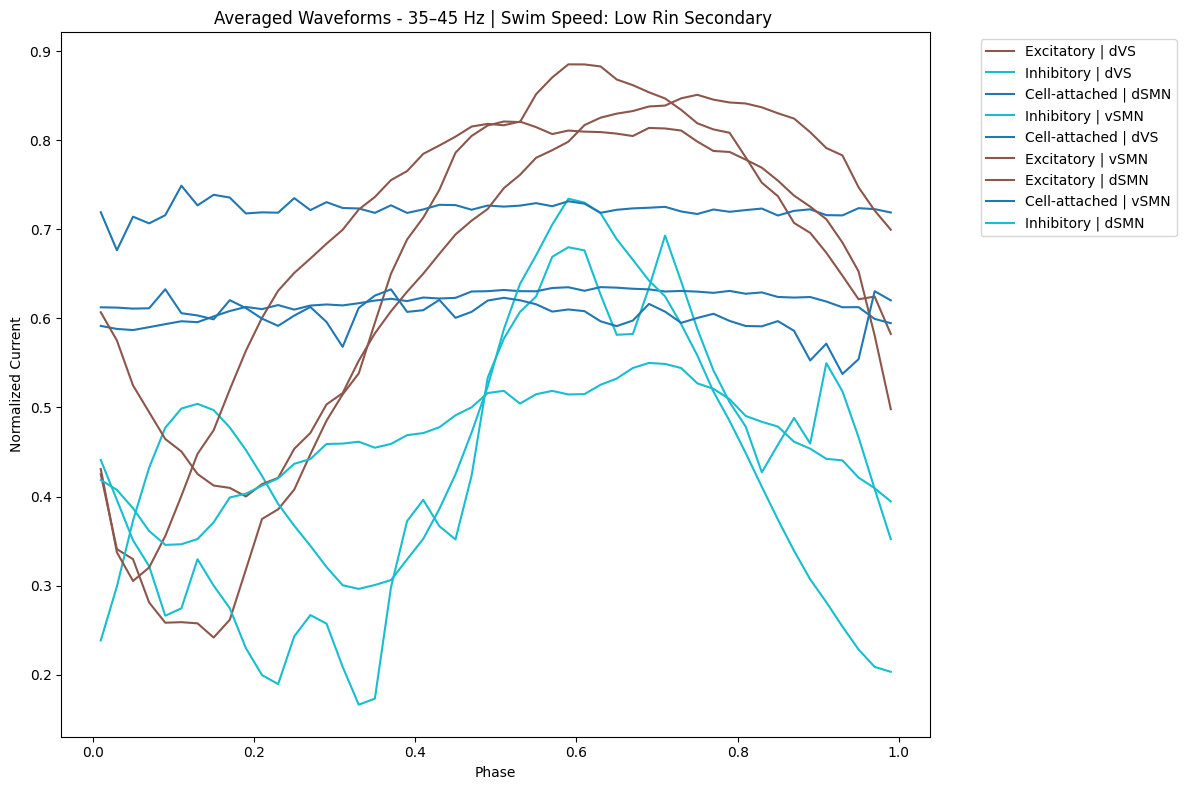

Plotting waveforms for frequency bin '35–45' and swimming speed 'primary'


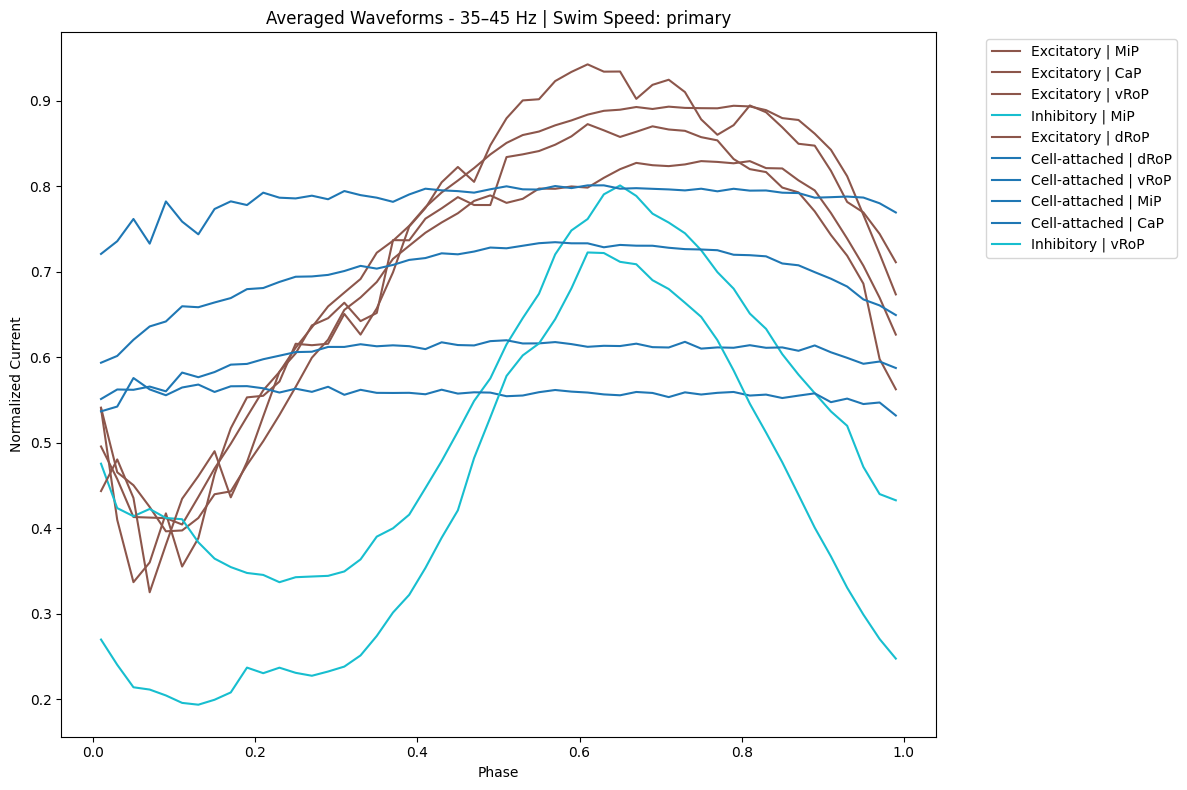

Plotting waveforms for frequency bin '45+' and swimming speed 'High Rin Secondary'
No matching waveforms found for ('45+', 'Excitatory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('45+', 'Excitatory', 'iSMN', 'High Rin Secondary')
No matching waveforms found for ('45+', 'Inhibitory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('45+', 'Inhibitory', 'iSMN', 'High Rin Secondary')


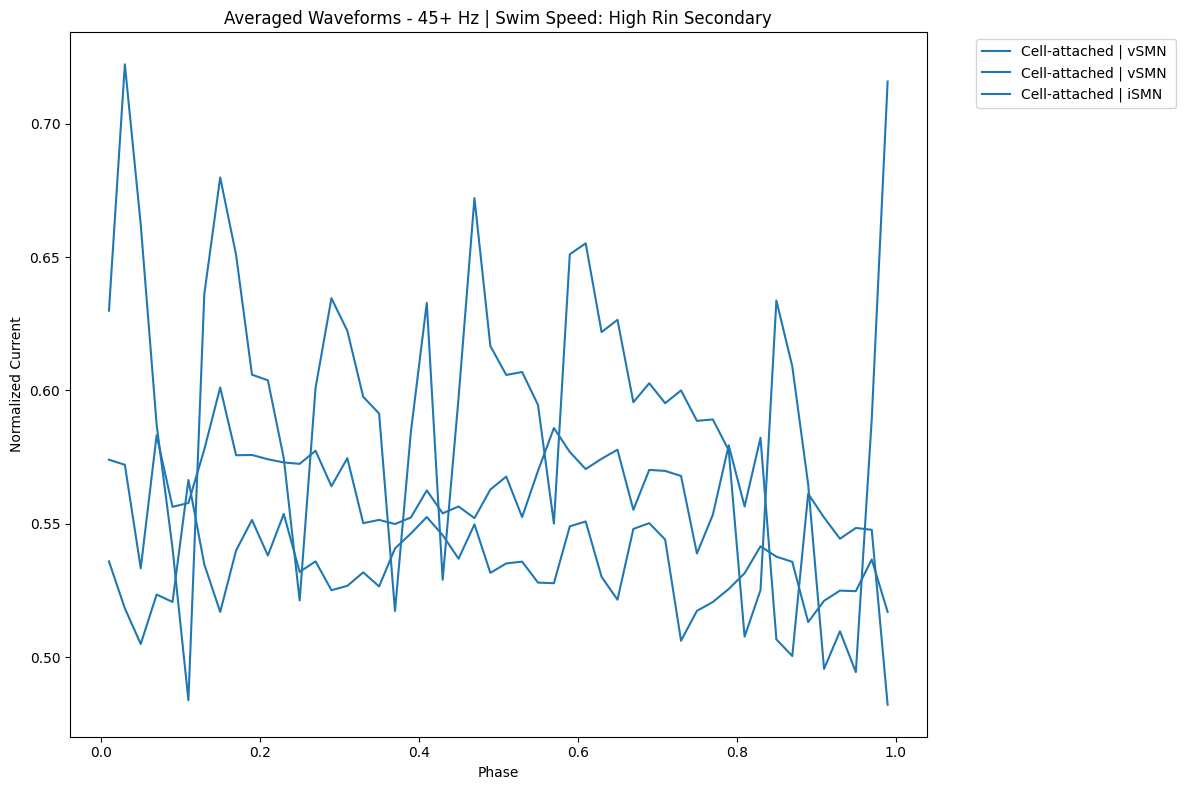

Plotting waveforms for frequency bin '45+' and swimming speed 'Low Rin Secondary '


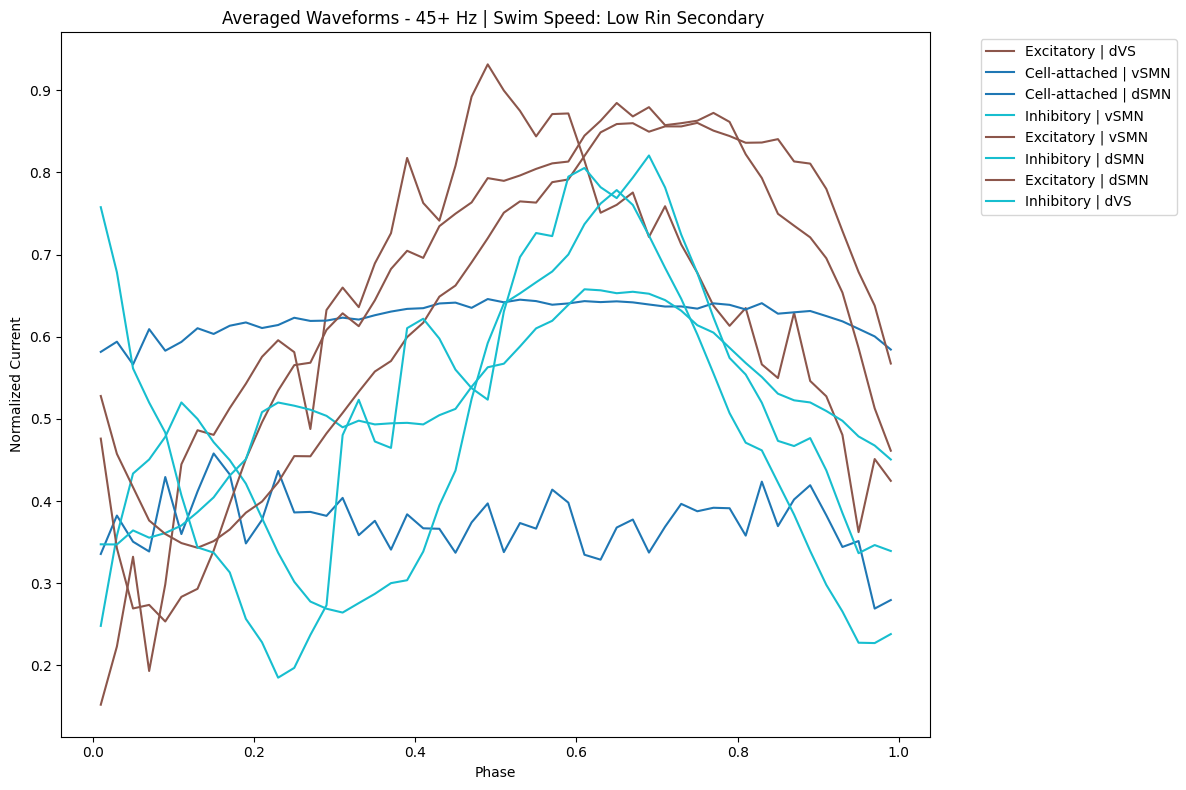

Plotting waveforms for frequency bin '45+' and swimming speed 'primary'


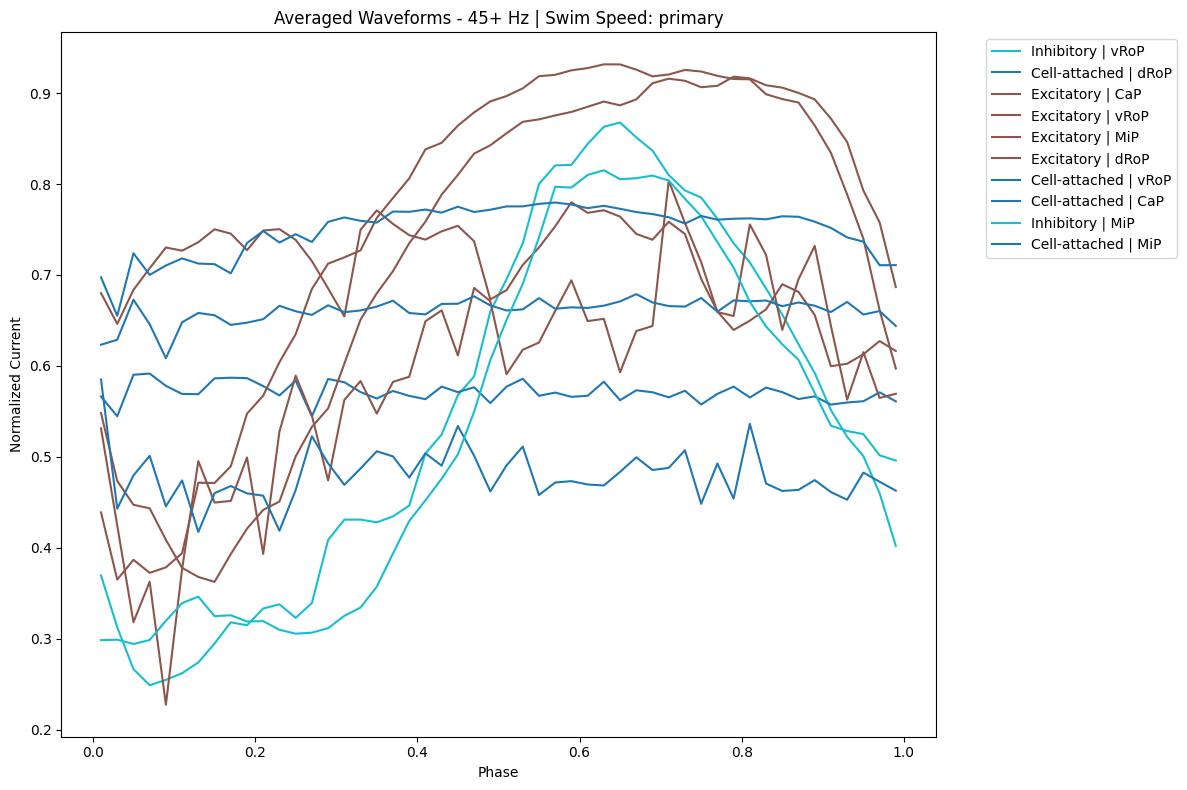

Plotting waveforms for frequency bin '<15' and swimming speed 'High Rin Secondary'
No matching waveforms found for ('<15', 'Excitatory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('<15', 'Excitatory', 'iSMN', 'High Rin Secondary')
No matching waveforms found for ('<15', 'Inhibitory', 'iSMN', 'High Rin Secondary')
  Skipping: No data for ('<15', 'Inhibitory', 'iSMN', 'High Rin Secondary')


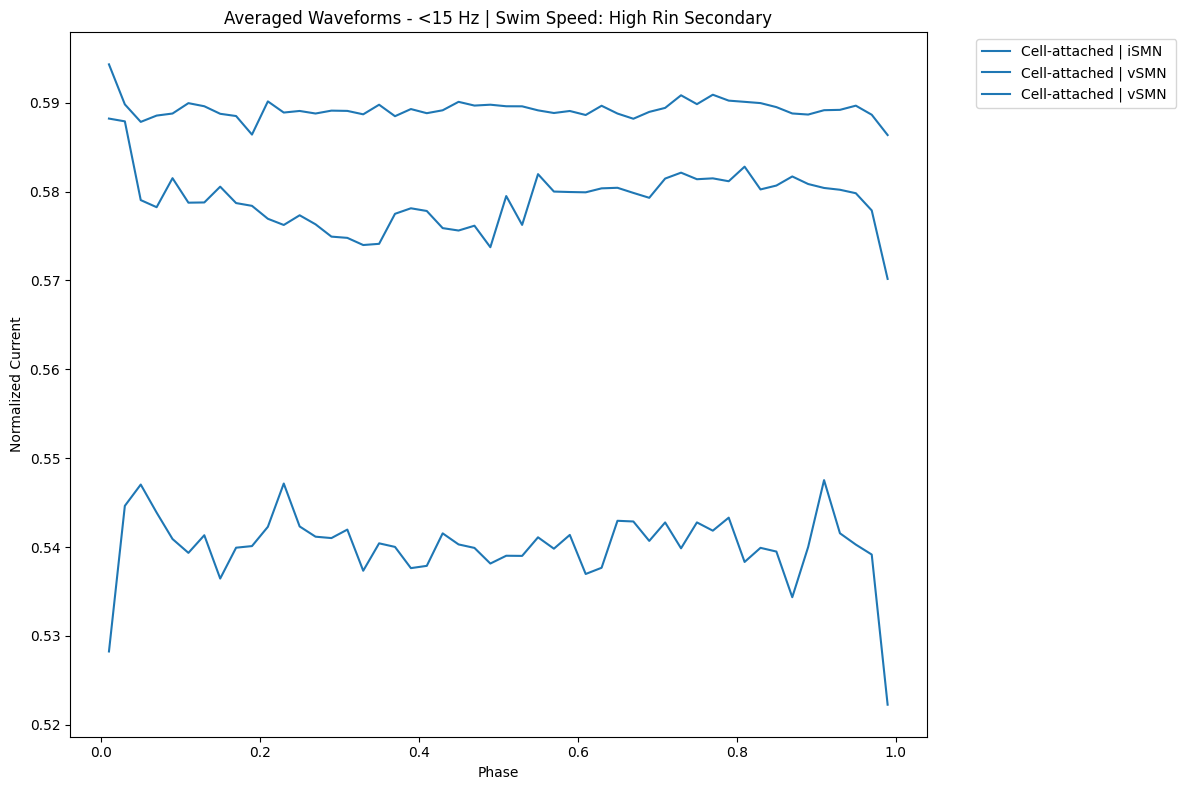

Plotting waveforms for frequency bin '<15' and swimming speed 'Low Rin Secondary '


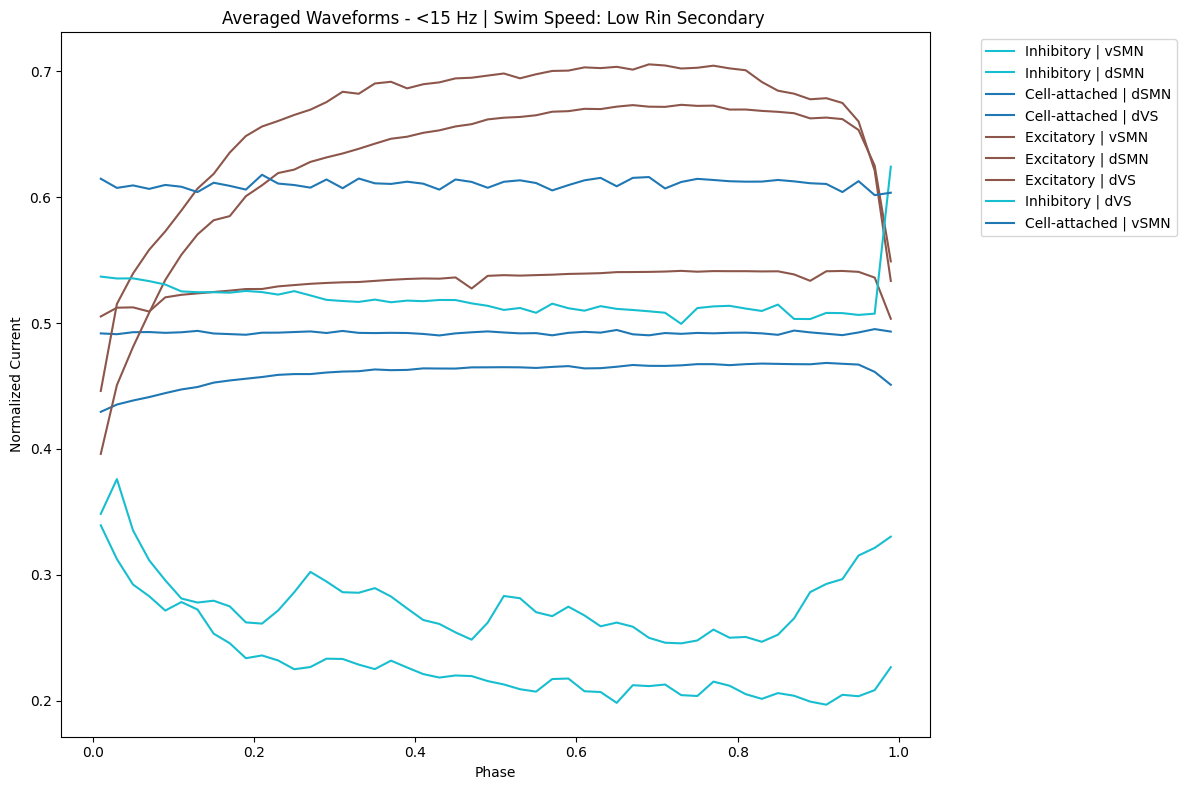

Plotting waveforms for frequency bin '<15' and swimming speed 'primary'


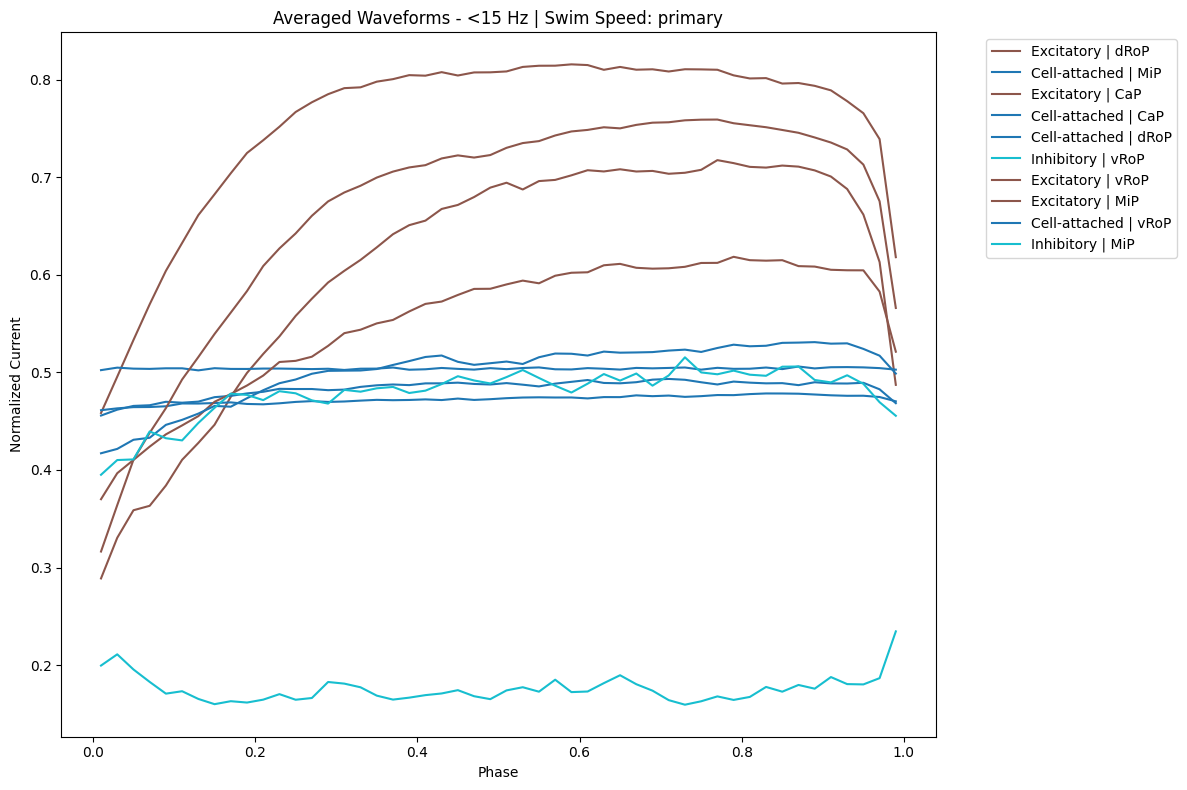

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Step 1: Group waveform keys by (frequency_bin, swimming_speed)
waveforms_by_group = defaultdict(list)
signal_types = set()

for freq, signal_type, cell_type, fast_slow in all_waveforms.keys():
    freq_bin = get_freq_bin(freq)
    cell_type_gen = group_iSMN(cell_type)
    grouped_key = (freq_bin, signal_type, cell_type_gen, fast_slow)
    group_key = (freq_bin, fast_slow)  # <--- group by freq + speed
    waveforms_by_group[group_key].append(grouped_key)
    signal_types.add(signal_type)

# Step 2: Assign colors to signal types
cmap = cm.get_cmap('tab10', len(signal_types))  # or use 'Set1', 'tab20', etc.
signal_type_colors = {stype: cmap(i) for i, stype in enumerate(sorted(signal_types))}

# Step 3: Plot each (frequency bin, swimming speed) group
for (freq_bin, speed_category), keys in sorted(waveforms_by_group.items()):
    plt.figure(figsize=(12, 8))
    print(f"Plotting waveforms for frequency bin '{freq_bin}' and swimming speed '{speed_category}'")

    plotted_any = False
    for key in set(keys):
        try:
            avg_waveform_df = average_waveforms_for_key(key)
            if avg_waveform_df is None or avg_waveform_df.empty:
                print(f"  Skipping: No data for {key}")
                continue

            signal_type = key[1]
            color = signal_type_colors.get(signal_type, 'gray')
            label = f"{signal_type} | {key[2]}"
            plt.plot(avg_waveform_df['Phase'], avg_waveform_df['Normalized Current'],
                     label=label, color=color)
            plotted_any = True
        except Exception as e:
            print(f"  Error with {key}: {e}")
            continue

    if plotted_any:
        plt.xlabel('Phase')
        plt.ylabel('Normalized Current')
        plt.title(f"Averaged Waveforms - {freq_bin} Hz | Swim Speed: {speed_category}")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print(f"  No valid waveforms to plot for ({freq_bin}, {speed_category})")


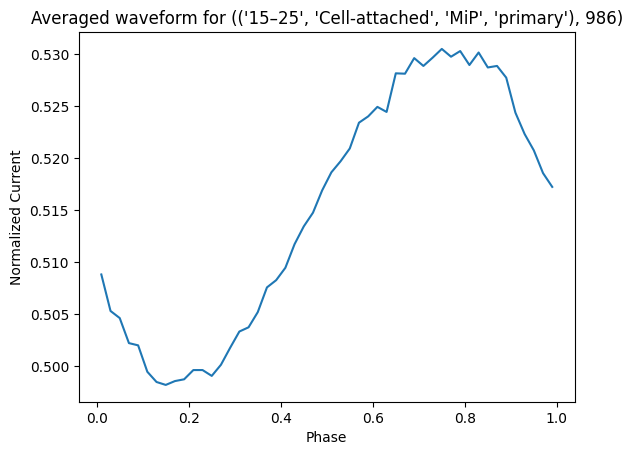

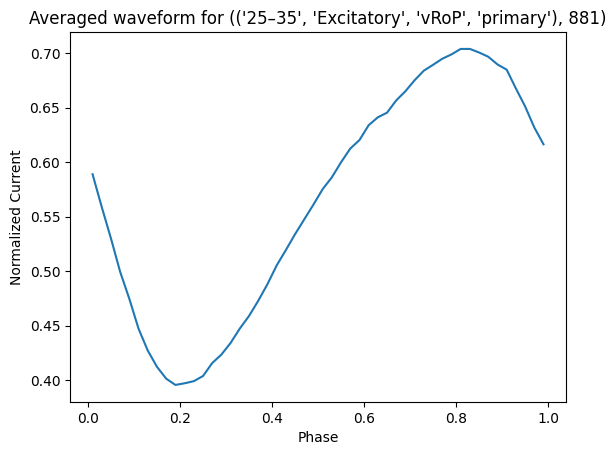

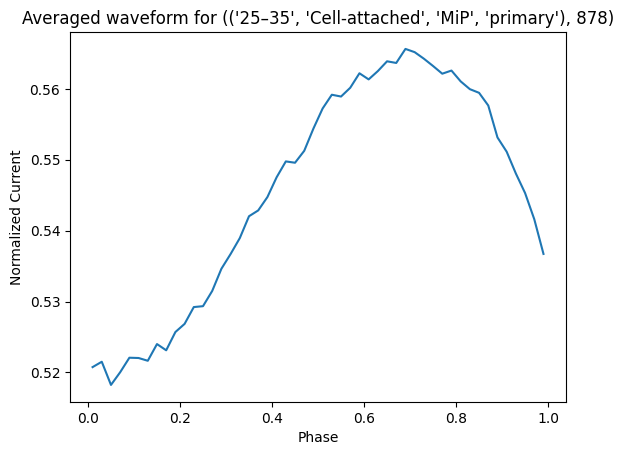

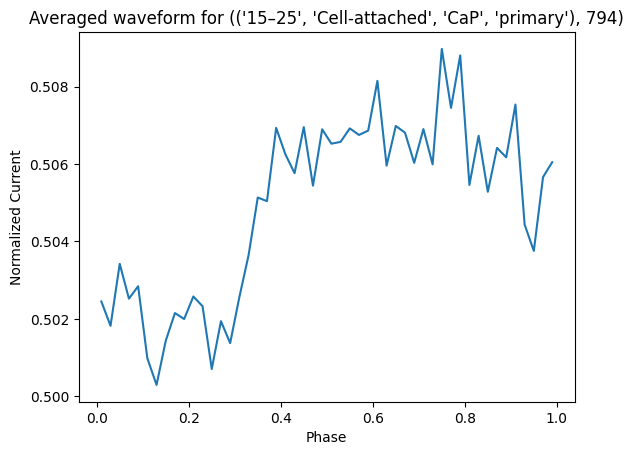

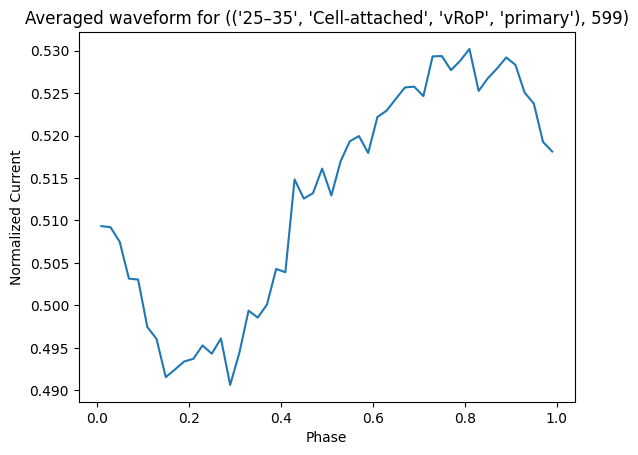

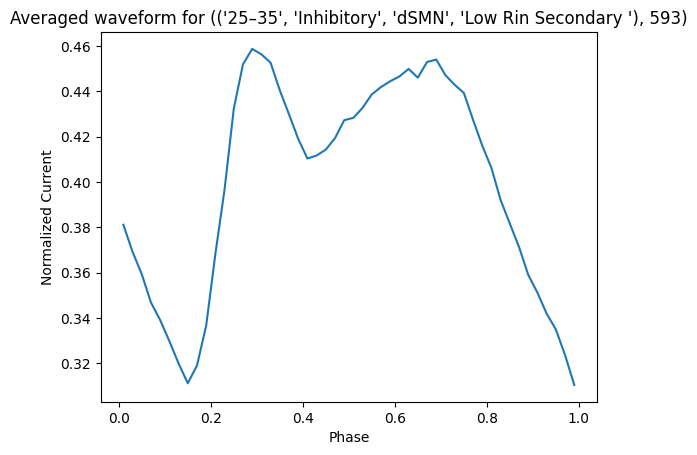

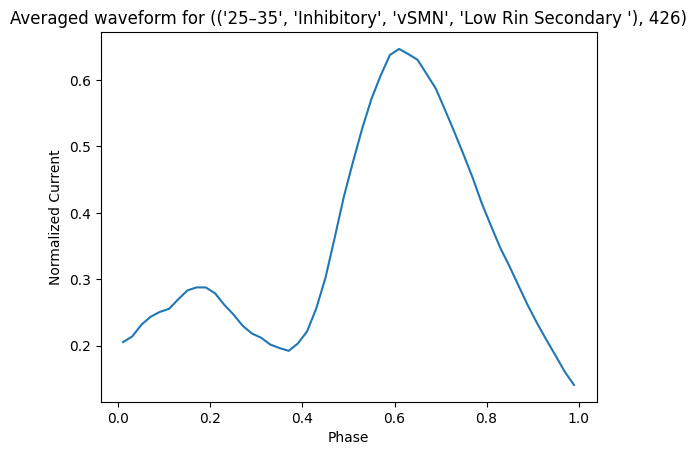

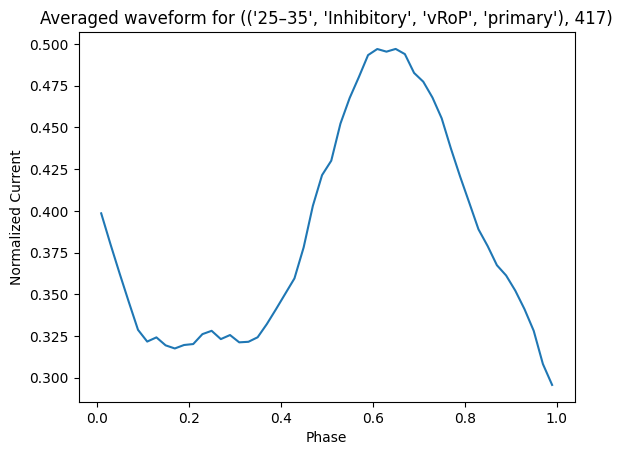

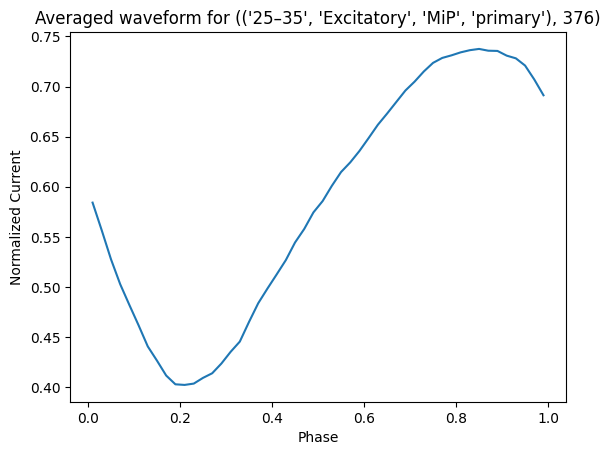

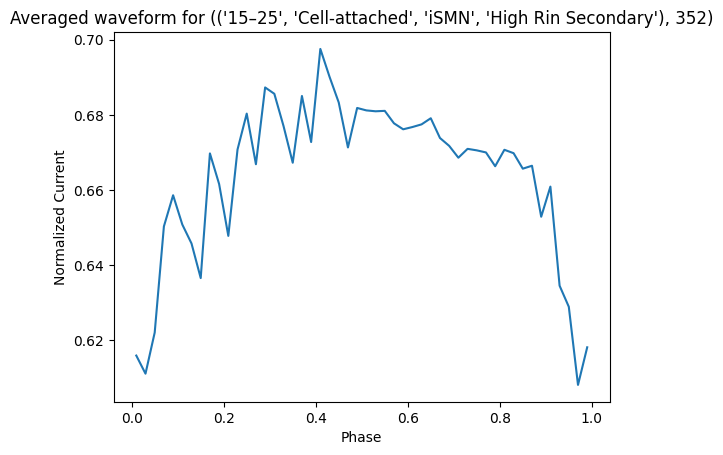

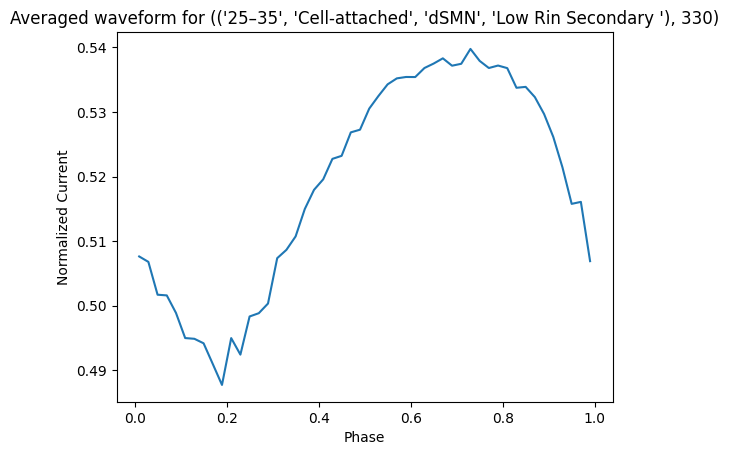

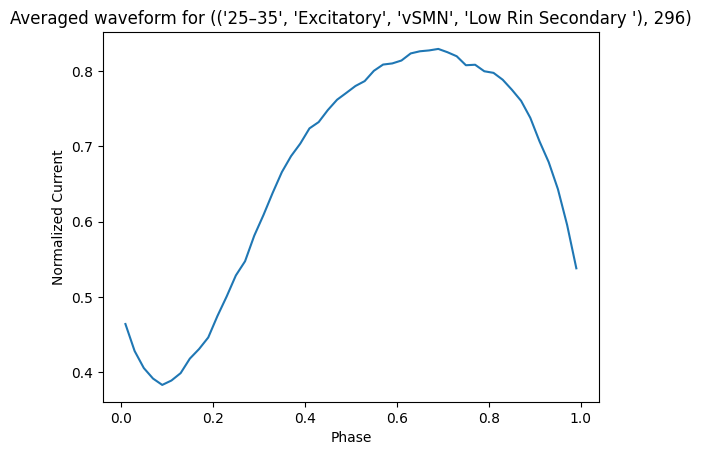

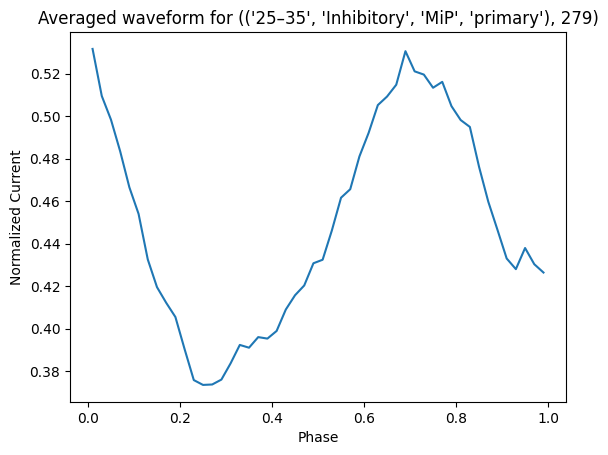

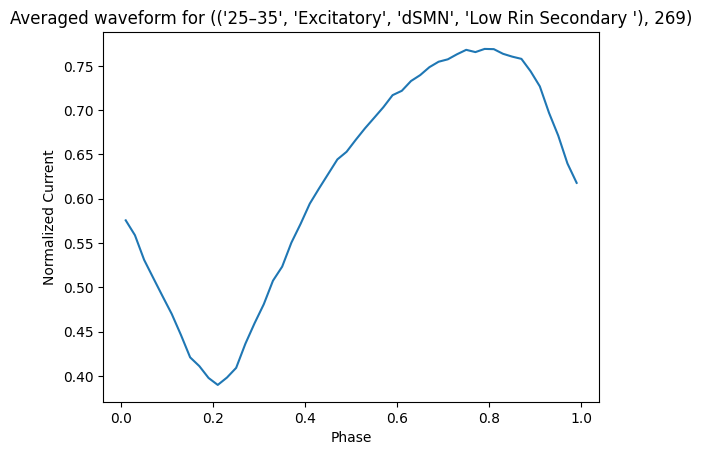

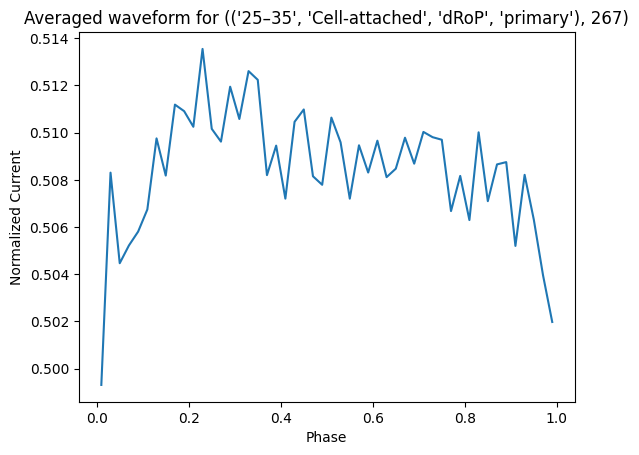

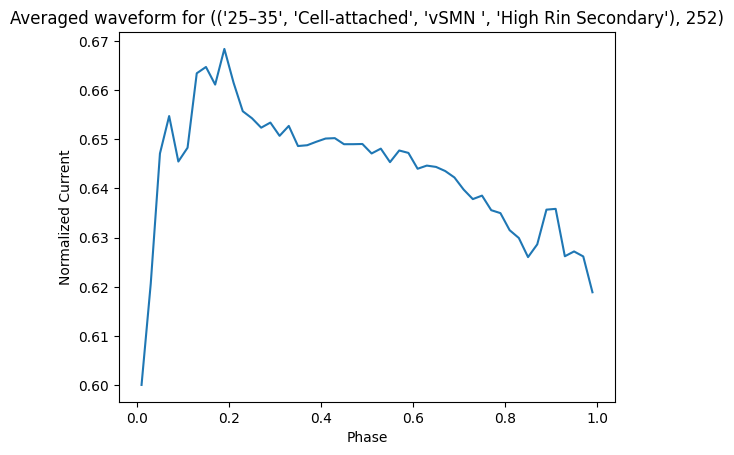

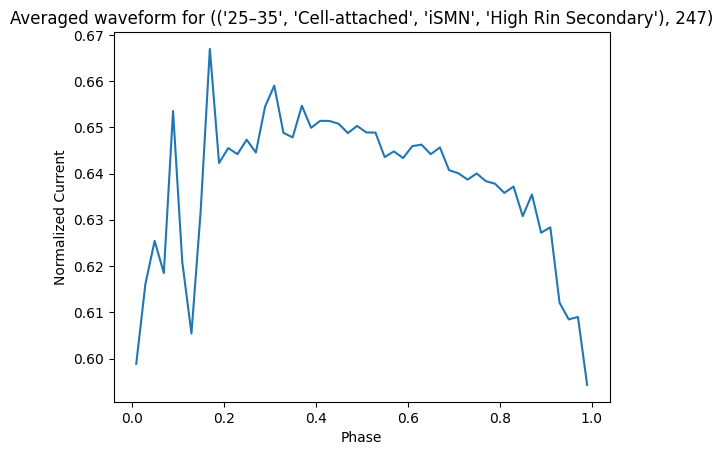

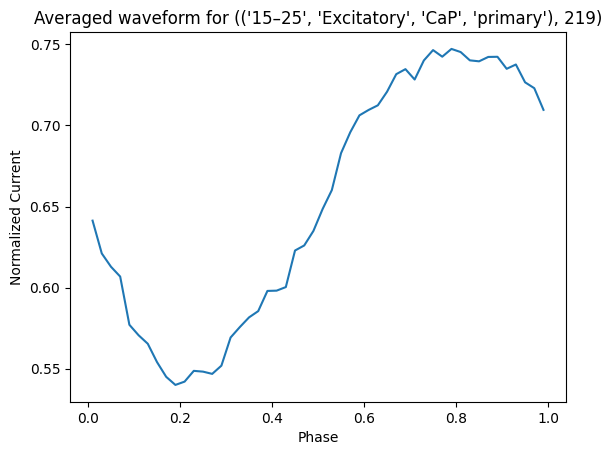

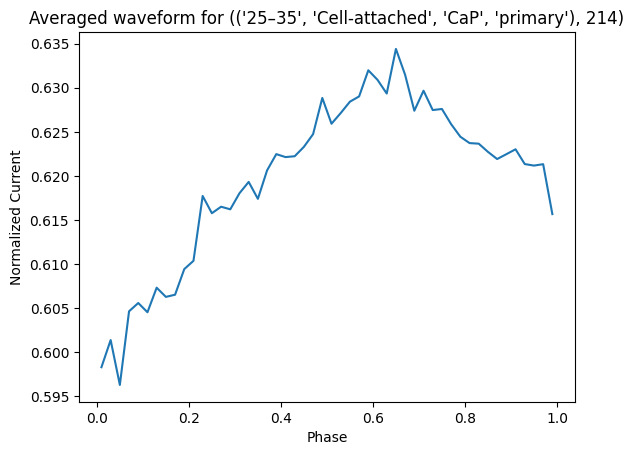

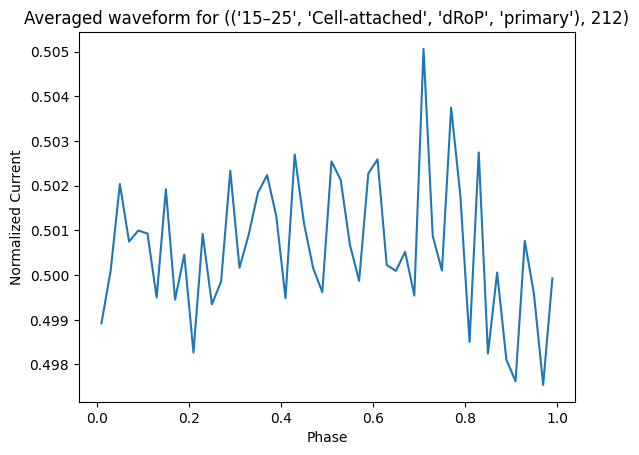

No matching waveforms found for ('25–35', 'Excitatory', 'iSMN', 'High Rin Secondary')


TypeError: 'NoneType' object is not subscriptable

In [ ]:
for key in key_counts.most_common():
    # print(key[0])
    avg_waveform_df = average_waveforms_for_key(key[0])
    plt.plot(avg_waveform_df['Phase'], avg_waveform_df['Normalized Current'])
    plt.xlabel('Phase')
    plt.ylabel('Normalized Current')
    plt.title(f'Averaged waveform for {key}')
    plt.show()